## Training (Text_Image_Transformer)

In [ ]:
pip install torchnet

In [ ]:
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FML Project') 

## Set Device

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Features and Labels

In [ ]:
label_path = sys.path[-1]+"/Data/labels.npy"
text_path = sys.path[-1]+"/Data/text_features_256.pt"
image_path = sys.path[-1]+"/Data/image_features.pt"

In [ ]:
labels = np.load(label_path)
print('Labels loaded!')

Labels loaded!


In [ ]:
text_features = torch.load(text_path)
print('Text features loaded!')

Text features loaded!


In [ ]:
image_features = torch.load(image_path)
print('Image features loaded!')

Image features loaded!


## Split Data

In [ ]:
df = pd.read_csv(sys.path[-1]+"/Data/df_final.csv")
train_ids = list(df[df['target_date'] < '2015-08-01'].index)
valid_ids = list(df[df['target_date'].between('2015-08-01','2015-10-01')].index)
test_ids = list(df[df['target_date'] > '2015-10-01'].index)
print(len(train_ids), len(valid_ids), len(test_ids))

14040 1910 2593


In [ ]:
dataset = TensorDataset([text_features.float(), image_features.float(), torch.tensor(labels).float()])

train_set = TensorDataset([torch.utils.data.Subset(dataset, train_ids)])
valid_set = TensorDataset([torch.utils.data.Subset(dataset, valid_ids)])
test_set = TensorDataset([torch.utils.data.Subset(dataset, test_ids)])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print('Datasets ready!')

Datasets ready!


## Evaluation Metrics

In [ ]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    # labels = labels.cpu().numpy().tolist()
    # preds = torch.argmax(preds, dim=1).cpu().numpy().tolist()
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

## Training

In [ ]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def load_model(model, name):
    weights = torch.load(name)
    model.load_state_dict(weights)
    return model

In [ ]:
def train_model(model, params, train_loader, valid_loader, test_loader, report_loss=True):

    device = params['device']
    n_epochs = params['n_epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    scheduler = params['scheduler']

    stop = 0
    best_valid_mcc = -1

    valid_metrics = {}
    test_metrics = {}
    train_loss, valid_loss, test_loss = [], [], []
    valid_a, valid_f1, valid_mcc, valid_cm = [], [], [], []
    test_a, test_f1, test_mcc, test_cm = [], [], [], []

    f = nn.Sigmoid()

    for epoch in range(n_epochs):

        model.train()
        train_loss_i, batch, total = 0.0, 0, 0
        for data in tqdm(train_loader):
            if params['model_type'] == 'unimodal':
                x, labels = data[0][0].to(device), data[0][1].to(device)
                preds = model(x)
            elif params['model_type'] == 'bimodal':
                x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                preds = model(x_txt, x_img)
            preds = f(preds).squeeze()
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_i += loss.item()
            batch += 1
            total += labels.shape[0]
            if report_loss and batch%100==0:
                print("Batch: {}, Training Loss: {:.4f}".format(batch, train_loss_i/total))
        train_loss_i /= len(train_loader.dataset)

        valid_loss_i = 0.0
        valid_preds, valid_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(valid_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                valid_loss_i += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
        valid_loss_i /= len(valid_loader.dataset)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)

        valid_a_i, valid_f1_i, valid_mcc_i, valid_cm_i = evaluate_metrics(valid_preds, valid_labels)

        test_loss_i = 0.0
        test_preds, test_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                test_loss_i += loss.item()
                test_preds.append(preds)
                test_labels.append(labels)
        test_loss_i /= len(test_loader.dataset)
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        test_a_i, test_f1_i, test_mcc_i, test_cm_i = evaluate_metrics(test_preds, test_labels)

        scheduler.step(valid_loss_i)  # decay learning rate by validation loss

        if valid_mcc_i > best_valid_mcc:
            save_model(model, sys.path[-1]+'/Models/'+params['model_name']+'.pt')
            print("Saved model at epoch {} with validation MCC score of {:.4f}%".format(epoch+1, valid_mcc_i))
            best_valid_mcc = valid_mcc_i

        if report_loss:
            print("\n")
            print("-" * 50)
            print("Epoch ", epoch+1)
            print("Training Loss: {:.4f}, Validation Loss: {:.4f}".format(train_loss_i, valid_loss_i))
            print('Validation Results: ')
            print("Accuracy: {:.4f}".format(valid_a_i))
            print("F1 Score: {:.4f}".format(valid_f1_i))
            print("MCC Score: {:.4f}".format(valid_mcc_i))
            print('Test Results: ')
            print("Accuracy: {:.4f}".format(test_a_i))
            print("F1 Score: {:.4f}".format(test_f1_i))
            print("MCC Score: {:.4f}".format(test_mcc_i))
            print("-" * 50)
            print("\n")
        
        if len(valid_loss) > 0:  
            if valid_loss_i <= valid_loss[-1]:
                stop = 0
            else:
                stop += 1
                if stop >= int(params['n_stop']):   # stop training when no improvement observed in consecutive epoches
                    print("Early stopped. No improvement in validation loss for params['n_stop'] consecutive epoches.")
                    break
        
        train_loss.append(train_loss_i)
        valid_loss.append(valid_loss_i)
        test_loss.append(test_loss_i)

        valid_a.append(valid_a_i)
        valid_f1.append(valid_f1_i)
        valid_mcc.append(valid_mcc_i)
        valid_cm.append(valid_cm_i)

        test_a.append(test_a_i)
        test_f1.append(test_f1_i)
        test_mcc.append(test_mcc_i)
        test_cm.append(test_cm_i)

    valid_metrics['acc'] = valid_a
    valid_metrics['f1'] = valid_f1
    valid_metrics['mcc'] = valid_mcc
    valid_metrics['cm'] = valid_cm

    test_metrics['acc'] = test_a
    test_metrics['f1'] = test_f1
    test_metrics['mcc'] = test_mcc
    test_metrics['cm'] = test_cm

    return train_loss, valid_loss, test_loss, valid_metrics, test_metrics

## Models

In [ ]:
class Text_Image_Transformer(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_Transformer, self).__init__()
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)

        # point-to-point feed-forward network
        self.feedforward = nn.Sequential(nn.Linear(params['hidden_size'], 4*params['hidden_size']),
                                         nn.ReLU(),
                                         nn.Linear(4*params['hidden_size'], params['hidden_size']))

        # functional layers
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(params['hidden_size'])
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout = nn.Dropout(params['transformer_dropout'])

        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)
        

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt) + x_img.unsqueeze(dim=1))
        # feed-forward network
        x_vt_ffn = self.feedforward(x_vt)
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt_ffn) + x_vt)
        # classification
        y = self.classifier(x_vt.squeeze())
        return y

In [ ]:
class Text_Image_Transformer2(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_Transformer2, self).__init__()
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)

        # point-to-point feed-forward network
        self.feedforward = nn.Sequential(nn.Linear(params['hidden_size'], 4*params['hidden_size']),
                                         nn.ReLU(),
                                         nn.Linear(4*params['hidden_size'], params['hidden_size']))

        # functional layers
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(params['hidden_size'])
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout = nn.Dropout(params['transformer_dropout'])

        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(2*params['hidden_size']),
                                       out_features=int(0.5*params['hidden_size']))
        self.classifier = nn.Linear(in_features=int(0.5*params['hidden_size']),
                                    out_features=1)
        

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim_txt(x_txt))
        x_img = self.relu(self.reduce_dim_img(x_img))
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt) + x_img.unsqueeze(dim=1))
        x_tv = self.norm(self.dropout(x_tv) + x_txt)
        # feed-forward network
        x_vt_ffn = self.feedforward(x_vt)
        x_tv_ffn = self.feedforward(x_tv)
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt_ffn) + x_vt)
        x_tv = self.norm(self.dropout(x_tv_ffn) + x_tv)
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with concatenation
        x_fused = torch.cat((x_vt.squeeze(), x_tv.squeeze()), dim=1)
        x_fused = self.dropout(self.concat_linear(x_fused))
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [ ]:
class Text_Image_Transformer3(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_Transformer3, self).__init__()
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)

        # point-to-point feed-forward network
        self.feedforward = nn.Sequential(nn.Linear(params['hidden_size'], 2*params['hidden_size']),
                                         nn.ReLU(),
                                         nn.Linear(2*params['hidden_size'], params['hidden_size']))

        # functional layers
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(params['hidden_size'])
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout = nn.Dropout(params['transformer_dropout'])

        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(2*params['hidden_size']),
                                       out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)
        

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.reduce_dim_txt(x_txt)
        x_img = self.reduce_dim_img(x_img)
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt) + x_img.unsqueeze(dim=1))
        x_tv = self.norm(self.dropout(x_tv) + x_txt)
        # feed-forward network
        x_vt_ffn = self.feedforward(x_vt)
        x_tv_ffn = self.feedforward(x_tv)
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt_ffn) + x_vt)
        x_tv = self.norm(self.dropout(x_tv_ffn) + x_tv)
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with statistical pooling
        x_fused = torch.stack((x_vt.squeeze(), x_tv.squeeze()), dim=1)
        x_std, x_mean = torch.std_mean(x_fused, dim=1)
        x_fused = torch.cat((x_std, x_mean), dim=1)
        x_fused = self.dropout(self.concat_linear(x_fused))
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [ ]:
class Text_Image_Transformer4(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_Transformer4, self).__init__()
        # multi-heads cross-attention
        self.mha_vt = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['vt_H'],
                                            dropout=params['vt_dropout'],
                                            batch_first=True)
        self.mha_tv = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                            num_heads=params['tv_H'],
                                            dropout=params['tv_dropout'],
                                            batch_first=True)

        # point-to-point feed-forward network
        self.feedforward = nn.Sequential(nn.Linear(params['hidden_size'], 2*params['hidden_size']),
                                         nn.ReLU(),
                                         nn.Linear(2*params['hidden_size'], params['hidden_size']))

        # functional layers
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(params['hidden_size'])
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout = nn.Dropout(params['transformer_dropout'])

        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)
        

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.reduce_dim_txt(x_txt)
        x_img = self.reduce_dim_img(x_img)
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # inter-modality cross-attention
        x_vt, _ = self.mha_vt(x_img.unsqueeze(dim=1), x_txt, x_txt)
        x_tv, _ = self.mha_vt(x_txt, x_img.unsqueeze(dim=1), x_img.unsqueeze(dim=1))
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt) + x_img.unsqueeze(dim=1))
        x_tv = self.norm(self.dropout(x_tv) + x_txt)
        # feed-forward network
        x_vt_ffn = self.feedforward(x_vt)
        x_tv_ffn = self.feedforward(x_tv)
        # residual connection and layer norm
        x_vt = self.norm(self.dropout(x_vt_ffn) + x_vt)
        x_tv = self.norm(self.dropout(x_tv_ffn) + x_tv)
        # temporal average as global representation
        x_tv = torch.mean(x_tv, dim=1)
        # fusion with Hadamard product
        x_fused = torch.mul(x_vt.squeeze(), x_tv.squeeze())
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

In [ ]:
class Text_Image_Transformer6(nn.Module):
    """
    Bimodal (Text+Image) classifier based on self-supervised embeddings and cross-attention.
    """
    def __init__(self, params):
        super(Text_Image_Transformer6, self).__init__()
        # multi-heads cross-attention
        self.mha = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                         num_heads=params['vt_H'],
                                         dropout=params['vt_dropout'],
                                         batch_first=True)

        # point-to-point feed-forward network
        self.feedforward = nn.Sequential(nn.Linear(params['hidden_size'], 2*params['hidden_size']),
                                         nn.ReLU(),
                                         nn.Linear(2*params['hidden_size'], params['hidden_size']))

        # functional layers
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(params['hidden_size'])
        self.dropout_txt = nn.Dropout(p=params['txt_dropout'])
        self.dropout_img = nn.Dropout(p=params['img_dropout'])
        self.dropout = nn.Dropout(params['transformer_dropout'])

        # fully connected layers
        self.reduce_dim_txt = nn.Linear(in_features=params['txt_embed_size'],
                                        out_features=params['hidden_size'])
        self.reduce_dim_img = nn.Linear(in_features=params['img_embed_size'],
                                        out_features=params['hidden_size'])
        self.concat_linear = nn.Linear(in_features=int(3*params['hidden_size']),
                                       out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)
        

    def forward(self, x_txt, x_img):
        """
        Input:
            x_txt   | text  self-supervised embeddings, shape = (batch_size, txt_embedding_size)
            x_img   | image self-supervised embeddings, shape = (batch_size, img_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
            x_vt    | fused image-text features, shape = (batch_size, hidden_size)
        """
        # dimension reduction
        x_txt = self.reduce_dim_txt(x_txt)
        x_img = self.reduce_dim_img(x_img)
        # dropout
        x_txt = self.dropout_txt(x_txt)
        x_img = self.dropout_img(x_img)
        # early fusion with multi-scale Hadamard products
        x_fused = torch.mul(x_txt, x_img.unsqueeze(dim=1))
        # inter-modality cross-attention
        x_fused_ca, _ = self.mha(x_fused, x_fused, x_fused)
        # residual connection and layer norm
        x_fused = self.norm(self.dropout(x_fused_ca) + x_fused)
        # feed-forward network
        x_fused_ffn = self.feedforward(x_fused)
        # residual connection and layer norm
        x_fused = self.norm(self.dropout(x_fused_ffn) + x_fused)
        # temporal average as global representation
        x_fused = torch.mean(x_fused, dim=1)
        # classification
        y = self.classifier(x_fused.squeeze())
        return y

## Bimodal

In [ ]:
model_params = {'txt_embed_size': 768,
                'img_embed_size': 2048,
                'hidden_size': 256,
                'txt_H': 4,
                'vt_H': 4,
                'tv_H': 4,
                'txt_dropout': 0.01,
                'img_dropout': 0.01,
                'vt_dropout': 0.01,
                'tv_dropout': 0.01,
                'fused_dropout': 0.01,
                'transformer_dropout': 0.01} 

best_acc, best_f1, best_mcc, best_cm = [], [], [], []

for i in range(5):

    model = Text_Image_Transformer3(model_params)
    model.to(device)
    criterion = nn.BCELoss()    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    train_params = {'n_epochs': 30,
                    'criterion': criterion,
                    'optimizer': optimizer,
                    'scheduler': scheduler,
                    'n_stop': 8,
                    'model_name': 'Text_Image_Transformer3',
                    'model_type': 'bimodal',
                    'device': device}

    train_loss, valid_loss, test_loss, valid_metrics, test_metrics = train_model(model, train_params, train_loader, valid_loader, test_loader)
        
    idx = np.argmax(test_metrics['mcc'])
    best_acc.append(test_metrics['acc'][idx])
    best_f1.append(test_metrics['f1'][idx])
    best_mcc.append(test_metrics['mcc'][idx])
    best_cm.append(test_metrics['cm'][idx])

    with open(sys.path[-1]+f"/Training Results/train_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(train_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_loss, f)
    with open(sys.path[-1]+f"/Training Results/test_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_metrics, f)
    with open(sys.path[-1]+f"/Training Results/test_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_metrics, f)

 25%|██▌       | 110/439 [00:01<00:05, 58.37it/s]

Batch: 100, Training Loss: 0.0221


 48%|████▊     | 209/439 [00:03<00:03, 58.99it/s]

Batch: 200, Training Loss: 0.0220


 71%|███████   | 310/439 [00:05<00:02, 61.37it/s]

Batch: 300, Training Loss: 0.0219


 94%|█████████▍| 412/439 [00:06<00:00, 60.04it/s]

Batch: 400, Training Loss: 0.0219


100%|██████████| 21/21 [00:01<00:00, 20.11it/s]


Saved model at epoch 1 with validation MCC score of 0.0324%


--------------------------------------------------
Epoch  1
Training Loss: 0.0219, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4560
F1 Score: 0.6250
MCC Score: 0.0324
Test Results: 
Accuracy: 0.5229
F1 Score: 0.6856
MCC Score: -0.0184
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.54it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 209/439 [00:03<00:03, 62.78it/s]

Batch: 200, Training Loss: 0.0218


 70%|██████▉   | 307/439 [00:04<00:02, 63.07it/s]

Batch: 300, Training Loss: 0.0218


 94%|█████████▍| 412/439 [00:06<00:00, 60.37it/s]

Batch: 400, Training Loss: 0.0218


100%|██████████| 21/21 [00:00<00:00, 24.69it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0218, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4654
F1 Score: 0.5301
MCC Score: -0.0381
Test Results: 
Accuracy: 0.5021
F1 Score: 0.5732
MCC Score: -0.0103
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.80it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 210/439 [00:03<00:03, 64.73it/s]

Batch: 200, Training Loss: 0.0217


 70%|███████   | 308/439 [00:04<00:02, 64.83it/s]

Batch: 300, Training Loss: 0.0217


 92%|█████████▏| 406/439 [00:06<00:00, 64.29it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 25.47it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0217, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.51it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 209/439 [00:03<00:03, 64.06it/s]

Batch: 200, Training Loss: 0.0217


 70%|██████▉   | 307/439 [00:04<00:02, 62.56it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 412/439 [00:06<00:00, 63.82it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.85it/s]


Saved model at epoch 4 with validation MCC score of 0.0549%


--------------------------------------------------
Epoch  4
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5534
F1 Score: 0.1161
MCC Score: 0.0549
Test Results: 
Accuracy: 0.4701
F1 Score: 0.1020
MCC Score: -0.0335
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.82it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 63.97it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 62.28it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 62.65it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.37it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4712
F1 Score: 0.6064
MCC Score: 0.0227
Test Results: 
Accuracy: 0.5280
F1 Score: 0.6568
MCC Score: 0.0296
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.65it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 64.15it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 63.77it/s]

Batch: 300, Training Loss: 0.0216


 94%|█████████▍| 413/439 [00:06<00:00, 64.69it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:01<00:00, 20.97it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4827
F1 Score: 0.5537
MCC Score: 0.0036
Test Results: 
Accuracy: 0.5210
F1 Score: 0.5983
MCC Score: 0.0270
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.76it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 209/439 [00:03<00:03, 64.60it/s]

Batch: 200, Training Loss: 0.0216


 70%|██████▉   | 307/439 [00:04<00:02, 63.23it/s]

Batch: 300, Training Loss: 0.0216


 94%|█████████▍| 412/439 [00:06<00:00, 63.97it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 25.14it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5450
F1 Score: 0.2998
MCC Score: 0.0430
Test Results: 
Accuracy: 0.4817
F1 Score: 0.2766
MCC Score: -0.0076
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.14it/s]

Batch: 100, Training Loss: 0.0216


 47%|████▋     | 208/439 [00:03<00:03, 61.12it/s]

Batch: 200, Training Loss: 0.0216


 70%|██████▉   | 306/439 [00:04<00:02, 63.26it/s]

Batch: 300, Training Loss: 0.0216


 94%|█████████▎| 411/439 [00:06<00:00, 63.42it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 21.78it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5225
F1 Score: 0.3863
MCC Score: 0.0135
Test Results: 
Accuracy: 0.4952
F1 Score: 0.4539
MCC Score: 0.0004
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 65.39it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 63.47it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 61.75it/s]

Batch: 300, Training Loss: 0.0215


 92%|█████████▏| 406/439 [00:06<00:00, 61.83it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.87it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0215, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4586
F1 Score: 0.6256
MCC Score: 0.0454
Test Results: 
Accuracy: 0.5237
F1 Score: 0.6854
MCC Score: -0.0057
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.30it/s]

Batch: 100, Training Loss: 0.0215


 48%|████▊     | 210/439 [00:03<00:03, 64.95it/s]

Batch: 200, Training Loss: 0.0215


 70%|███████   | 308/439 [00:04<00:02, 63.89it/s]

Batch: 300, Training Loss: 0.0215


 94%|█████████▍| 413/439 [00:06<00:00, 64.28it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 22.36it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0215, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4691
F1 Score: 0.5854
MCC Score: -0.0021
Test Results: 
Accuracy: 0.5195
F1 Score: 0.6436
MCC Score: 0.0089
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.27it/s]

Batch: 100, Training Loss: 0.0215


 48%|████▊     | 209/439 [00:03<00:03, 62.16it/s]

Batch: 200, Training Loss: 0.0213


 70%|██████▉   | 307/439 [00:04<00:02, 63.97it/s]

Batch: 300, Training Loss: 0.0213


 94%|█████████▍| 412/439 [00:06<00:00, 63.46it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 24.76it/s]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  11
Training Loss: 0.0213, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.4433
MCC Score: -0.0033
Test Results: 
Accuracy: 0.5006
F1 Score: 0.4615
MCC Score: 0.0111
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.09it/s]

Batch: 100, Training Loss: 0.0209


 48%|████▊     | 210/439 [00:03<00:03, 64.74it/s]

Batch: 200, Training Loss: 0.0210


 70%|███████   | 308/439 [00:04<00:02, 62.90it/s]

Batch: 300, Training Loss: 0.0210


 92%|█████████▏| 406/439 [00:06<00:00, 62.31it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 24.57it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0210, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5225
F1 Score: 0.4328
MCC Score: 0.0251
Test Results: 
Accuracy: 0.4998
F1 Score: 0.4417
MCC Score: 0.0129
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.80it/s]

Batch: 100, Training Loss: 0.0205


 48%|████▊     | 210/439 [00:03<00:03, 63.03it/s]

Batch: 200, Training Loss: 0.0207


 70%|███████   | 308/439 [00:04<00:02, 63.46it/s]

Batch: 300, Training Loss: 0.0207


 94%|█████████▍| 413/439 [00:06<00:00, 64.22it/s]

Batch: 400, Training Loss: 0.0207


100%|██████████| 21/21 [00:00<00:00, 25.38it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0208, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.5238
MCC Score: 0.0043
Test Results: 
Accuracy: 0.5029
F1 Score: 0.5541
MCC Score: -0.0032
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 61.94it/s]

Batch: 100, Training Loss: 0.0202


 48%|████▊     | 209/439 [00:03<00:03, 64.51it/s]

Batch: 200, Training Loss: 0.0204


 70%|██████▉   | 307/439 [00:04<00:02, 63.53it/s]

Batch: 300, Training Loss: 0.0204


 94%|█████████▍| 412/439 [00:06<00:00, 63.93it/s]

Batch: 400, Training Loss: 0.0205


100%|██████████| 21/21 [00:00<00:00, 24.87it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0205, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.4941
MCC Score: 0.0210
Test Results: 
Accuracy: 0.5079
F1 Score: 0.5008
MCC Score: 0.0198
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.27it/s]

Batch: 100, Training Loss: 0.0201


 48%|████▊     | 210/439 [00:03<00:03, 64.45it/s]

Batch: 200, Training Loss: 0.0203


 70%|███████   | 308/439 [00:04<00:02, 61.97it/s]

Batch: 300, Training Loss: 0.0202


 92%|█████████▏| 406/439 [00:06<00:00, 63.52it/s]

Batch: 400, Training Loss: 0.0202


100%|██████████| 21/21 [00:00<00:00, 25.45it/s]


Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  15
Training Loss: 0.0202, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5147
F1 Score: 0.5154
MCC Score: 0.0384
Test Results: 
Accuracy: 0.5017
F1 Score: 0.5211
MCC Score: 0.0019
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 65.11it/s]

Batch: 100, Training Loss: 0.0198


 48%|████▊     | 210/439 [00:03<00:03, 63.49it/s]

Batch: 200, Training Loss: 0.0196


 70%|███████   | 308/439 [00:04<00:02, 64.16it/s]

Batch: 300, Training Loss: 0.0195


 92%|█████████▏| 406/439 [00:06<00:00, 63.18it/s]

Batch: 400, Training Loss: 0.0195


100%|██████████| 21/21 [00:00<00:00, 24.18it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0195, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.5360
MCC Score: 0.0304
Test Results: 
Accuracy: 0.5040
F1 Score: 0.5550
MCC Score: -0.0008
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.32it/s]

Batch: 100, Training Loss: 0.0191


 48%|████▊     | 210/439 [00:03<00:03, 64.99it/s]

Batch: 200, Training Loss: 0.0191


 70%|███████   | 308/439 [00:04<00:02, 63.52it/s]

Batch: 300, Training Loss: 0.0191


 92%|█████████▏| 406/439 [00:06<00:00, 64.05it/s]

Batch: 400, Training Loss: 0.0192


100%|██████████| 21/21 [00:00<00:00, 25.01it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0192, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.4766
MCC Score: -0.0249
Test Results: 
Accuracy: 0.5087
F1 Score: 0.5149
MCC Score: 0.0186
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 65.13it/s]

Batch: 100, Training Loss: 0.0184


 48%|████▊     | 210/439 [00:03<00:03, 62.46it/s]

Batch: 200, Training Loss: 0.0187


 70%|███████   | 308/439 [00:04<00:02, 61.70it/s]

Batch: 300, Training Loss: 0.0188


 94%|█████████▍| 413/439 [00:06<00:00, 64.27it/s]

Batch: 400, Training Loss: 0.0188


100%|██████████| 21/21 [00:00<00:00, 24.91it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0189, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.4921
MCC Score: -0.0056
Test Results: 
Accuracy: 0.5013
F1 Score: 0.5159
MCC Score: 0.0022
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.16it/s]

Batch: 100, Training Loss: 0.0187


 48%|████▊     | 210/439 [00:03<00:03, 63.18it/s]

Batch: 200, Training Loss: 0.0186


 70%|███████   | 308/439 [00:04<00:02, 63.80it/s]

Batch: 300, Training Loss: 0.0186


 92%|█████████▏| 406/439 [00:06<00:00, 62.17it/s]

Batch: 400, Training Loss: 0.0185


100%|██████████| 21/21 [00:00<00:00, 24.40it/s]


Epoch 00019: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  19
Training Loss: 0.0185, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.4806
F1 Score: 0.5000
MCC Score: -0.0236
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5399
MCC Score: 0.0080
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.76it/s]

Batch: 100, Training Loss: 0.0176


 48%|████▊     | 210/439 [00:03<00:03, 62.55it/s]

Batch: 200, Training Loss: 0.0177


 70%|███████   | 308/439 [00:04<00:02, 63.47it/s]

Batch: 300, Training Loss: 0.0179


 92%|█████████▏| 406/439 [00:06<00:00, 63.75it/s]

Batch: 400, Training Loss: 0.0180


100%|██████████| 21/21 [00:00<00:00, 25.04it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0180, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.4943
MCC Score: -0.0048
Test Results: 
Accuracy: 0.5052
F1 Score: 0.5288
MCC Score: 0.0079
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 59.01it/s]

Batch: 100, Training Loss: 0.0177


 47%|████▋     | 208/439 [00:03<00:03, 62.35it/s]

Batch: 200, Training Loss: 0.0177


 70%|██████▉   | 306/439 [00:04<00:02, 63.61it/s]

Batch: 300, Training Loss: 0.0177


 94%|█████████▎| 411/439 [00:06<00:00, 64.88it/s]

Batch: 400, Training Loss: 0.0177


100%|██████████| 21/21 [00:00<00:00, 24.60it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0178, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.5081
MCC Score: -0.0065
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5470
MCC Score: 0.0046
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.92it/s]

Batch: 100, Training Loss: 0.0172


 48%|████▊     | 210/439 [00:03<00:03, 63.55it/s]

Batch: 200, Training Loss: 0.0175


 70%|███████   | 308/439 [00:04<00:02, 64.55it/s]

Batch: 300, Training Loss: 0.0175


 92%|█████████▏| 406/439 [00:06<00:00, 62.84it/s]

Batch: 400, Training Loss: 0.0175


100%|██████████| 21/21 [00:00<00:00, 25.01it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0175, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4471
MCC Score: -0.0198
Test Results: 
Accuracy: 0.5056
F1 Score: 0.4937
MCC Score: 0.0161
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.42it/s]

Batch: 100, Training Loss: 0.0173


 48%|████▊     | 210/439 [00:03<00:03, 63.48it/s]

Batch: 200, Training Loss: 0.0173


 70%|███████   | 308/439 [00:04<00:02, 62.88it/s]

Batch: 300, Training Loss: 0.0173


 94%|█████████▍| 413/439 [00:06<00:00, 64.63it/s]

Batch: 400, Training Loss: 0.0173


100%|██████████| 21/21 [00:00<00:00, 24.74it/s]


Epoch 00023: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  23
Training Loss: 0.0173, Validation Loss: 0.0068
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4899
MCC Score: -0.0246
Test Results: 
Accuracy: 0.5048
F1 Score: 0.5321
MCC Score: 0.0063
--------------------------------------------------




 25%|██▌       | 110/439 [00:01<00:05, 62.05it/s]

Batch: 100, Training Loss: 0.0171


 47%|████▋     | 208/439 [00:03<00:03, 64.60it/s]

Batch: 200, Training Loss: 0.0170


 71%|███████▏  | 313/439 [00:04<00:01, 65.33it/s]

Batch: 300, Training Loss: 0.0169


 94%|█████████▎| 411/439 [00:06<00:00, 63.03it/s]

Batch: 400, Training Loss: 0.0169


100%|██████████| 21/21 [00:00<00:00, 25.17it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0169, Validation Loss: 0.0067
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.4776
MCC Score: -0.0115
Test Results: 
Accuracy: 0.5060
F1 Score: 0.5127
MCC Score: 0.0131
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.89it/s]

Batch: 100, Training Loss: 0.0166


 48%|████▊     | 210/439 [00:03<00:03, 64.99it/s]

Batch: 200, Training Loss: 0.0169


 70%|███████   | 308/439 [00:04<00:02, 61.87it/s]

Batch: 300, Training Loss: 0.0168


 94%|█████████▍| 413/439 [00:06<00:00, 63.74it/s]

Batch: 400, Training Loss: 0.0167


100%|██████████| 21/21 [00:00<00:00, 24.46it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0167, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.4827
F1 Score: 0.4827
MCC Score: -0.0263
Test Results: 
Accuracy: 0.5083
F1 Score: 0.5194
MCC Score: 0.0168
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.30it/s]

Batch: 100, Training Loss: 0.0164


 48%|████▊     | 210/439 [00:03<00:03, 63.93it/s]

Batch: 200, Training Loss: 0.0165


 70%|███████   | 308/439 [00:04<00:02, 64.36it/s]

Batch: 300, Training Loss: 0.0165


 92%|█████████▏| 406/439 [00:06<00:00, 63.85it/s]

Batch: 400, Training Loss: 0.0165


100%|██████████| 21/21 [00:00<00:00, 24.43it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0165, Validation Loss: 0.0068
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.4712
MCC Score: -0.0180
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5061
MCC Score: 0.0068
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.49it/s]

Batch: 100, Training Loss: 0.0164


 48%|████▊     | 209/439 [00:03<00:03, 63.40it/s]

Batch: 200, Training Loss: 0.0164


 70%|██████▉   | 307/439 [00:04<00:02, 63.44it/s]

Batch: 300, Training Loss: 0.0165


 94%|█████████▍| 412/439 [00:06<00:00, 64.08it/s]

Batch: 400, Training Loss: 0.0164


100%|██████████| 21/21 [00:00<00:00, 25.07it/s]


Epoch 00027: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  27
Training Loss: 0.0164, Validation Loss: 0.0069
Validation Results: 
Accuracy: 0.4901
F1 Score: 0.4660
MCC Score: -0.0198
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5035
MCC Score: 0.0090
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.31it/s]

Batch: 100, Training Loss: 0.0160


 48%|████▊     | 210/439 [00:03<00:03, 61.56it/s]

Batch: 200, Training Loss: 0.0162


 70%|███████   | 308/439 [00:04<00:02, 62.56it/s]

Batch: 300, Training Loss: 0.0162


 92%|█████████▏| 406/439 [00:06<00:00, 63.39it/s]

Batch: 400, Training Loss: 0.0161


100%|██████████| 21/21 [00:00<00:00, 25.50it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0162, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.4837
MCC Score: -0.0207
Test Results: 
Accuracy: 0.5040
F1 Score: 0.5234
MCC Score: 0.0066
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.25it/s]

Batch: 100, Training Loss: 0.0164


 48%|████▊     | 210/439 [00:03<00:03, 63.77it/s]

Batch: 200, Training Loss: 0.0162


 70%|███████   | 308/439 [00:04<00:02, 63.50it/s]

Batch: 300, Training Loss: 0.0161


 92%|█████████▏| 406/439 [00:06<00:00, 62.05it/s]

Batch: 400, Training Loss: 0.0161


100%|██████████| 21/21 [00:00<00:00, 22.41it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0162, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.4822
F1 Score: 0.4759
MCC Score: -0.0295
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5147
MCC Score: 0.0050
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.83it/s]

Batch: 100, Training Loss: 0.0162


 48%|████▊     | 210/439 [00:03<00:03, 64.31it/s]

Batch: 200, Training Loss: 0.0159


 70%|███████   | 308/439 [00:04<00:02, 63.65it/s]

Batch: 300, Training Loss: 0.0160


 94%|█████████▍| 413/439 [00:06<00:00, 64.50it/s]

Batch: 400, Training Loss: 0.0161


100%|██████████| 21/21 [00:00<00:00, 24.82it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0161, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.4759
MCC Score: -0.0217
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5129
MCC Score: 0.0139
--------------------------------------------------




 25%|██▌       | 110/439 [00:01<00:05, 62.42it/s]

Batch: 100, Training Loss: 0.0221


 47%|████▋     | 208/439 [00:03<00:03, 62.95it/s]

Batch: 200, Training Loss: 0.0220


 70%|██████▉   | 306/439 [00:04<00:02, 63.80it/s]

Batch: 300, Training Loss: 0.0219


 94%|█████████▎| 411/439 [00:06<00:00, 63.75it/s]

Batch: 400, Training Loss: 0.0219


100%|██████████| 21/21 [00:00<00:00, 24.82it/s]


Saved model at epoch 1 with validation MCC score of 0.0129%


--------------------------------------------------
Epoch  1
Training Loss: 0.0219, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4581
F1 Score: 0.6210
MCC Score: 0.0129
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6839
MCC Score: 0.0045
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.64it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 210/439 [00:03<00:03, 62.01it/s]

Batch: 200, Training Loss: 0.0217


 70%|███████   | 308/439 [00:04<00:02, 62.38it/s]

Batch: 300, Training Loss: 0.0217


 92%|█████████▏| 406/439 [00:06<00:00, 62.60it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.82it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0217, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.51it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 210/439 [00:03<00:03, 62.96it/s]

Batch: 200, Training Loss: 0.0217


 70%|███████   | 308/439 [00:04<00:02, 63.54it/s]

Batch: 300, Training Loss: 0.0217


 92%|█████████▏| 406/439 [00:06<00:00, 64.42it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.33it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6236
MCC Score: 0.0013
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6860
MCC Score: 0.0054
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 64.13it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 209/439 [00:03<00:03, 64.65it/s]

Batch: 200, Training Loss: 0.0217


 70%|██████▉   | 307/439 [00:04<00:02, 62.45it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 412/439 [00:06<00:00, 63.12it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.69it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5461
F1 Score: 0.0000
MCC Score: 0.0000
Test Results: 
Accuracy: 0.4747
F1 Score: 0.0000
MCC Score: -0.0206
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.82it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 210/439 [00:03<00:03, 62.57it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 64.44it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 64.88it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 25.04it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6222
MCC Score: -0.0040
Test Results: 
Accuracy: 0.5280
F1 Score: 0.6862
MCC Score: 0.0289
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:04, 65.62it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 63.97it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 63.63it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 62.05it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 25.18it/s]


Saved model at epoch 6 with validation MCC score of 0.0152%


--------------------------------------------------
Epoch  6
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4649
F1 Score: 0.6117
MCC Score: 0.0152
Test Results: 
Accuracy: 0.5256
F1 Score: 0.6709
MCC Score: 0.0178
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.48it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 64.02it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 64.22it/s]

Batch: 300, Training Loss: 0.0216


 94%|█████████▍| 413/439 [00:06<00:00, 64.32it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.74it/s]


Saved model at epoch 7 with validation MCC score of 0.0156%


--------------------------------------------------
Epoch  7
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5450
F1 Score: 0.0920
MCC Score: 0.0156
Test Results: 
Accuracy: 0.4709
F1 Score: 0.1068
MCC Score: -0.0303
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 61.99it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 209/439 [00:03<00:03, 63.34it/s]

Batch: 200, Training Loss: 0.0216


 70%|██████▉   | 307/439 [00:04<00:02, 64.34it/s]

Batch: 300, Training Loss: 0.0216


 94%|█████████▍| 412/439 [00:06<00:00, 63.95it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.90it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5450
F1 Score: 0.0203
MCC Score: -0.0008
Test Results: 
Accuracy: 0.4747
F1 Score: 0.0299
MCC Score: -0.0095
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.86it/s]

Batch: 100, Training Loss: 0.0215


 48%|████▊     | 210/439 [00:03<00:03, 63.79it/s]

Batch: 200, Training Loss: 0.0215


 70%|███████   | 308/439 [00:04<00:02, 62.55it/s]

Batch: 300, Training Loss: 0.0215


 92%|█████████▏| 406/439 [00:06<00:00, 61.30it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.32it/s]


Saved model at epoch 9 with validation MCC score of 0.0487%


--------------------------------------------------
Epoch  9
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5026
F1 Score: 0.5728
MCC Score: 0.0487
Test Results: 
Accuracy: 0.5179
F1 Score: 0.5811
MCC Score: 0.0241
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.50it/s]

Batch: 100, Training Loss: 0.0214


 48%|████▊     | 210/439 [00:03<00:03, 62.48it/s]

Batch: 200, Training Loss: 0.0213


 70%|███████   | 308/439 [00:04<00:02, 64.52it/s]

Batch: 300, Training Loss: 0.0214


 92%|█████████▏| 406/439 [00:06<00:00, 63.63it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 24.37it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0214, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.3696
MCC Score: -0.0314
Test Results: 
Accuracy: 0.4832
F1 Score: 0.3767
MCC Score: -0.0153
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.08it/s]

Batch: 100, Training Loss: 0.0212


 48%|████▊     | 209/439 [00:03<00:03, 64.48it/s]

Batch: 200, Training Loss: 0.0211


 70%|██████▉   | 307/439 [00:04<00:02, 64.78it/s]

Batch: 300, Training Loss: 0.0212


 94%|█████████▍| 412/439 [00:06<00:00, 64.51it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 24.68it/s]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  11
Training Loss: 0.0212, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5662
MCC Score: 0.0418
Test Results: 
Accuracy: 0.5245
F1 Score: 0.6072
MCC Score: 0.0329
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.25it/s]

Batch: 100, Training Loss: 0.0208


 48%|████▊     | 210/439 [00:03<00:03, 61.72it/s]

Batch: 200, Training Loss: 0.0209


 70%|███████   | 308/439 [00:04<00:02, 63.14it/s]

Batch: 300, Training Loss: 0.0208


 92%|█████████▏| 406/439 [00:06<00:00, 63.68it/s]

Batch: 400, Training Loss: 0.0207


100%|██████████| 21/21 [00:00<00:00, 24.69it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0207, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5204
F1 Score: 0.4535
MCC Score: 0.0272
Test Results: 
Accuracy: 0.4983
F1 Score: 0.4613
MCC Score: 0.0059
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.49it/s]

Batch: 100, Training Loss: 0.0202


 48%|████▊     | 210/439 [00:03<00:03, 63.30it/s]

Batch: 200, Training Loss: 0.0202


 70%|███████   | 308/439 [00:04<00:02, 64.15it/s]

Batch: 300, Training Loss: 0.0203


 94%|█████████▍| 413/439 [00:06<00:00, 64.97it/s]

Batch: 400, Training Loss: 0.0203


100%|██████████| 21/21 [00:00<00:00, 24.38it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0203, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.5693
MCC Score: 0.0369
Test Results: 
Accuracy: 0.5218
F1 Score: 0.6078
MCC Score: 0.0263
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.29it/s]

Batch: 100, Training Loss: 0.0200


 48%|████▊     | 210/439 [00:03<00:03, 65.01it/s]

Batch: 200, Training Loss: 0.0199


 70%|███████   | 308/439 [00:04<00:02, 64.06it/s]

Batch: 300, Training Loss: 0.0199


 92%|█████████▏| 406/439 [00:06<00:00, 64.03it/s]

Batch: 400, Training Loss: 0.0200


100%|██████████| 21/21 [00:00<00:00, 24.80it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0200, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4869
F1 Score: 0.5182
MCC Score: -0.0059
Test Results: 
Accuracy: 0.5168
F1 Score: 0.5699
MCC Score: 0.0243
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.82it/s]

Batch: 100, Training Loss: 0.0194


 48%|████▊     | 210/439 [00:03<00:03, 62.40it/s]

Batch: 200, Training Loss: 0.0196


 70%|███████   | 308/439 [00:04<00:02, 63.36it/s]

Batch: 300, Training Loss: 0.0197


 92%|█████████▏| 406/439 [00:06<00:00, 63.17it/s]

Batch: 400, Training Loss: 0.0196


100%|██████████| 21/21 [00:00<00:00, 24.34it/s]


Epoch 00015: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  15
Training Loss: 0.0197, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5306
MCC Score: 0.0177
Test Results: 
Accuracy: 0.5125
F1 Score: 0.5698
MCC Score: 0.0147
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.63it/s]

Batch: 100, Training Loss: 0.0190


 48%|████▊     | 210/439 [00:03<00:03, 64.36it/s]

Batch: 200, Training Loss: 0.0189


 70%|███████   | 308/439 [00:04<00:02, 64.00it/s]

Batch: 300, Training Loss: 0.0190


 92%|█████████▏| 406/439 [00:06<00:00, 62.57it/s]

Batch: 400, Training Loss: 0.0190


100%|██████████| 21/21 [00:00<00:00, 24.53it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0190, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.4965
MCC Score: 0.0159
Test Results: 
Accuracy: 0.5264
F1 Score: 0.5459
MCC Score: 0.0511
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.73it/s]

Batch: 100, Training Loss: 0.0184


 48%|████▊     | 210/439 [00:03<00:03, 63.28it/s]

Batch: 200, Training Loss: 0.0184


 70%|███████   | 308/439 [00:04<00:02, 63.58it/s]

Batch: 300, Training Loss: 0.0184


 92%|█████████▏| 406/439 [00:06<00:00, 63.66it/s]

Batch: 400, Training Loss: 0.0186


100%|██████████| 21/21 [00:00<00:00, 24.90it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0186, Validation Loss: 0.0063
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5104
MCC Score: 0.0005
Test Results: 
Accuracy: 0.5237
F1 Score: 0.5725
MCC Score: 0.0392
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.62it/s]

Batch: 100, Training Loss: 0.0180


 48%|████▊     | 210/439 [00:03<00:03, 61.95it/s]

Batch: 200, Training Loss: 0.0182


 70%|███████   | 308/439 [00:04<00:02, 63.72it/s]

Batch: 300, Training Loss: 0.0182


 94%|█████████▍| 413/439 [00:06<00:00, 64.22it/s]

Batch: 400, Training Loss: 0.0182


100%|██████████| 21/21 [00:00<00:00, 24.83it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0183, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.4334
MCC Score: 0.0036
Test Results: 
Accuracy: 0.5133
F1 Score: 0.4794
MCC Score: 0.0362
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.26it/s]

Batch: 100, Training Loss: 0.0179


 48%|████▊     | 209/439 [00:03<00:03, 63.63it/s]

Batch: 200, Training Loss: 0.0178


 70%|██████▉   | 307/439 [00:04<00:02, 62.83it/s]

Batch: 300, Training Loss: 0.0179


 94%|█████████▍| 412/439 [00:06<00:00, 61.05it/s]

Batch: 400, Training Loss: 0.0179


100%|██████████| 21/21 [00:00<00:00, 24.61it/s]


Epoch 00019: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  19
Training Loss: 0.0180, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.4086
MCC Score: -0.0052
Test Results: 
Accuracy: 0.5110
F1 Score: 0.4778
MCC Score: 0.0313
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.49it/s]

Batch: 100, Training Loss: 0.0171


 48%|████▊     | 210/439 [00:03<00:03, 64.15it/s]

Batch: 200, Training Loss: 0.0172


 70%|███████   | 308/439 [00:04<00:02, 64.02it/s]

Batch: 300, Training Loss: 0.0174


 94%|█████████▍| 413/439 [00:06<00:00, 65.15it/s]

Batch: 400, Training Loss: 0.0174


100%|██████████| 21/21 [00:00<00:00, 24.93it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0174, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5079
F1 Score: 0.4598
MCC Score: 0.0079
Test Results: 
Accuracy: 0.5114
F1 Score: 0.4914
MCC Score: 0.0294
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 60.57it/s]

Batch: 100, Training Loss: 0.0171


 48%|████▊     | 209/439 [00:03<00:03, 62.21it/s]

Batch: 200, Training Loss: 0.0173


 70%|██████▉   | 307/439 [00:04<00:02, 62.90it/s]

Batch: 300, Training Loss: 0.0172


 94%|█████████▍| 412/439 [00:06<00:00, 63.10it/s]

Batch: 400, Training Loss: 0.0172


100%|██████████| 21/21 [00:00<00:00, 24.60it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0172, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4963
F1 Score: 0.4828
MCC Score: -0.0037
Test Results: 
Accuracy: 0.5179
F1 Score: 0.5336
MCC Score: 0.0351
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.50it/s]

Batch: 100, Training Loss: 0.0166


 48%|████▊     | 210/439 [00:03<00:03, 62.58it/s]

Batch: 200, Training Loss: 0.0169


 70%|███████   | 308/439 [00:04<00:02, 62.14it/s]

Batch: 300, Training Loss: 0.0168


 92%|█████████▏| 406/439 [00:06<00:00, 61.40it/s]

Batch: 400, Training Loss: 0.0170


100%|██████████| 21/21 [00:00<00:00, 25.27it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0170, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5026
MCC Score: -0.0017
Test Results: 
Accuracy: 0.5214
F1 Score: 0.5544
MCC Score: 0.0381
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.33it/s]

Batch: 100, Training Loss: 0.0165


 48%|████▊     | 210/439 [00:03<00:03, 64.36it/s]

Batch: 200, Training Loss: 0.0166


 70%|███████   | 308/439 [00:04<00:02, 63.53it/s]

Batch: 300, Training Loss: 0.0166


 94%|█████████▍| 413/439 [00:06<00:00, 64.39it/s]

Batch: 400, Training Loss: 0.0167


100%|██████████| 21/21 [00:00<00:00, 24.36it/s]


Epoch 00023: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  23
Training Loss: 0.0168, Validation Loss: 0.0065
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.4609
MCC Score: -0.0189
Test Results: 
Accuracy: 0.5172
F1 Score: 0.5170
MCC Score: 0.0369
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.85it/s]

Batch: 100, Training Loss: 0.0163


 48%|████▊     | 210/439 [00:03<00:03, 64.21it/s]

Batch: 200, Training Loss: 0.0165


 70%|███████   | 308/439 [00:04<00:02, 63.69it/s]

Batch: 300, Training Loss: 0.0165


 92%|█████████▏| 406/439 [00:06<00:00, 63.36it/s]

Batch: 400, Training Loss: 0.0164


100%|██████████| 21/21 [00:00<00:00, 25.62it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0164, Validation Loss: 0.0069
Validation Results: 
Accuracy: 0.4906
F1 Score: 0.4924
MCC Score: -0.0098
Test Results: 
Accuracy: 0.5129
F1 Score: 0.5402
MCC Score: 0.0225
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.22it/s]

Batch: 100, Training Loss: 0.0160


 48%|████▊     | 210/439 [00:03<00:03, 62.36it/s]

Batch: 200, Training Loss: 0.0162


 70%|███████   | 308/439 [00:04<00:02, 62.31it/s]

Batch: 300, Training Loss: 0.0163


 92%|█████████▏| 406/439 [00:06<00:00, 63.15it/s]

Batch: 400, Training Loss: 0.0163


100%|██████████| 21/21 [00:00<00:00, 24.48it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0163, Validation Loss: 0.0067
Validation Results: 
Accuracy: 0.4995
F1 Score: 0.4493
MCC Score: -0.0094
Test Results: 
Accuracy: 0.5087
F1 Score: 0.4867
MCC Score: 0.0243
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.51it/s]

Batch: 100, Training Loss: 0.0162


 48%|████▊     | 210/439 [00:03<00:03, 64.44it/s]

Batch: 200, Training Loss: 0.0162


 70%|███████   | 308/439 [00:04<00:02, 64.48it/s]

Batch: 300, Training Loss: 0.0163


 92%|█████████▏| 406/439 [00:06<00:00, 62.15it/s]

Batch: 400, Training Loss: 0.0162


100%|██████████| 21/21 [00:00<00:00, 21.21it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0162, Validation Loss: 0.0069
Validation Results: 
Accuracy: 0.4963
F1 Score: 0.4673
MCC Score: -0.0089
Test Results: 
Accuracy: 0.5118
F1 Score: 0.5112
MCC Score: 0.0262
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.58it/s]

Batch: 100, Training Loss: 0.0159


 48%|████▊     | 210/439 [00:03<00:03, 64.09it/s]

Batch: 200, Training Loss: 0.0161


 70%|███████   | 308/439 [00:04<00:02, 64.21it/s]

Batch: 300, Training Loss: 0.0162


 94%|█████████▍| 413/439 [00:06<00:00, 64.50it/s]

Batch: 400, Training Loss: 0.0161


100%|██████████| 21/21 [00:00<00:00, 24.76it/s]


Epoch 00027: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  27
Training Loss: 0.0161, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5000
MCC Score: -0.0009
Test Results: 
Accuracy: 0.5160
F1 Score: 0.5421
MCC Score: 0.0289
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.02it/s]

Batch: 100, Training Loss: 0.0160


 48%|████▊     | 209/439 [00:03<00:03, 62.71it/s]

Batch: 200, Training Loss: 0.0160


 70%|██████▉   | 307/439 [00:04<00:02, 63.96it/s]

Batch: 300, Training Loss: 0.0159


 94%|█████████▍| 412/439 [00:06<00:00, 64.83it/s]

Batch: 400, Training Loss: 0.0158


100%|██████████| 21/21 [00:00<00:00, 24.99it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0158, Validation Loss: 0.0069
Validation Results: 
Accuracy: 0.4885
F1 Score: 0.4705
MCC Score: -0.0209
Test Results: 
Accuracy: 0.5175
F1 Score: 0.5267
MCC Score: 0.0357
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.03it/s]

Batch: 100, Training Loss: 0.0156


 48%|████▊     | 210/439 [00:03<00:03, 63.59it/s]

Batch: 200, Training Loss: 0.0157


 70%|███████   | 308/439 [00:04<00:02, 62.41it/s]

Batch: 300, Training Loss: 0.0157


 92%|█████████▏| 406/439 [00:06<00:00, 59.99it/s]

Batch: 400, Training Loss: 0.0158


100%|██████████| 21/21 [00:00<00:00, 24.45it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0157, Validation Loss: 0.0071
Validation Results: 
Accuracy: 0.4911
F1 Score: 0.5000
MCC Score: -0.0061
Test Results: 
Accuracy: 0.5195
F1 Score: 0.5482
MCC Score: 0.0352
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.18it/s]

Batch: 100, Training Loss: 0.0158


 48%|████▊     | 210/439 [00:03<00:03, 64.36it/s]

Batch: 200, Training Loss: 0.0158


 70%|███████   | 308/439 [00:04<00:02, 63.93it/s]

Batch: 300, Training Loss: 0.0157


 94%|█████████▍| 413/439 [00:06<00:00, 64.10it/s]

Batch: 400, Training Loss: 0.0158


100%|██████████| 21/21 [00:00<00:00, 24.74it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0157, Validation Loss: 0.0070
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4649
MCC Score: -0.0141
Test Results: 
Accuracy: 0.5118
F1 Score: 0.5161
MCC Score: 0.0252
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.28it/s]

Batch: 100, Training Loss: 0.0221


 48%|████▊     | 210/439 [00:03<00:03, 63.81it/s]

Batch: 200, Training Loss: 0.0220


 70%|███████   | 308/439 [00:04<00:02, 63.21it/s]

Batch: 300, Training Loss: 0.0219


 92%|█████████▏| 406/439 [00:06<00:00, 61.41it/s]

Batch: 400, Training Loss: 0.0219


100%|██████████| 21/21 [00:00<00:00, 25.10it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0219, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5461
F1 Score: 0.0000
MCC Score: 0.0000
Test Results: 
Accuracy: 0.4751
F1 Score: 0.0000
MCC Score: 0.0000
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.81it/s]

Batch: 100, Training Loss: 0.0218


 48%|████▊     | 210/439 [00:03<00:03, 62.77it/s]

Batch: 200, Training Loss: 0.0219


 70%|███████   | 308/439 [00:04<00:02, 62.18it/s]

Batch: 300, Training Loss: 0.0219


 92%|█████████▏| 406/439 [00:06<00:00, 63.51it/s]

Batch: 400, Training Loss: 0.0218


100%|██████████| 21/21 [00:00<00:00, 25.10it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0218, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.43it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 210/439 [00:03<00:03, 64.01it/s]

Batch: 200, Training Loss: 0.0217


 70%|███████   | 308/439 [00:04<00:02, 62.38it/s]

Batch: 300, Training Loss: 0.0217


 92%|█████████▏| 406/439 [00:06<00:00, 62.50it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.84it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5351
F1 Score: 0.1638
MCC Score: -0.0053
Test Results: 
Accuracy: 0.4682
F1 Score: 0.1300
MCC Score: -0.0401
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 65.14it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 63.50it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 62.31it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 413/439 [00:06<00:00, 64.23it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.87it/s]


Saved model at epoch 4 with validation MCC score of 0.0345%


--------------------------------------------------
Epoch  4
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4812
F1 Score: 0.5993
MCC Score: 0.0345
Test Results: 
Accuracy: 0.5280
F1 Score: 0.6402
MCC Score: 0.0335
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.23it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 209/439 [00:03<00:03, 62.85it/s]

Batch: 200, Training Loss: 0.0217


 70%|██████▉   | 307/439 [00:04<00:02, 62.86it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 412/439 [00:06<00:00, 63.41it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.85it/s]


Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0217, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.31it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 61.93it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 63.27it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 63.72it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.36it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.5228
MCC Score: -0.0075
Test Results: 
Accuracy: 0.5029
F1 Score: 0.5331
MCC Score: 0.0018
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.92it/s]

Batch: 100, Training Loss: 0.0215


 48%|████▊     | 209/439 [00:03<00:03, 62.86it/s]

Batch: 200, Training Loss: 0.0215


 70%|██████▉   | 307/439 [00:04<00:02, 64.28it/s]

Batch: 300, Training Loss: 0.0215


 94%|█████████▍| 412/439 [00:06<00:00, 64.37it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.25it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0215, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5173
F1 Score: 0.4917
MCC Score: 0.0339
Test Results: 
Accuracy: 0.4906
F1 Score: 0.4826
MCC Score: -0.0150
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.72it/s]

Batch: 100, Training Loss: 0.0215


 48%|████▊     | 210/439 [00:03<00:03, 62.20it/s]

Batch: 200, Training Loss: 0.0215


 70%|███████   | 308/439 [00:04<00:02, 63.29it/s]

Batch: 300, Training Loss: 0.0215


 94%|█████████▍| 413/439 [00:06<00:00, 64.27it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.69it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0215, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5199
F1 Score: 0.4641
MCC Score: 0.0294
Test Results: 
Accuracy: 0.4863
F1 Score: 0.4496
MCC Score: -0.0186
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.52it/s]

Batch: 100, Training Loss: 0.0214


 48%|████▊     | 210/439 [00:03<00:03, 62.57it/s]

Batch: 200, Training Loss: 0.0214


 70%|███████   | 308/439 [00:04<00:02, 62.87it/s]

Batch: 300, Training Loss: 0.0214


 92%|█████████▏| 406/439 [00:06<00:00, 62.91it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 22.16it/s]


Epoch 00009: reducing learning rate of group 0 to 2.5000e-05.
Saved model at epoch 9 with validation MCC score of 0.0429%


--------------------------------------------------
Epoch  9
Training Loss: 0.0214, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5742
MCC Score: 0.0429
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5938
MCC Score: -0.0086
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.47it/s]

Batch: 100, Training Loss: 0.0212


 48%|████▊     | 210/439 [00:03<00:03, 64.41it/s]

Batch: 200, Training Loss: 0.0212


 70%|███████   | 308/439 [00:04<00:02, 63.04it/s]

Batch: 300, Training Loss: 0.0212


 92%|█████████▏| 406/439 [00:06<00:00, 62.05it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 24.83it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0212, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4880
F1 Score: 0.4353
MCC Score: -0.0331
Test Results: 
Accuracy: 0.4809
F1 Score: 0.4603
MCC Score: -0.0322
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.25it/s]

Batch: 100, Training Loss: 0.0211


 48%|████▊     | 210/439 [00:03<00:03, 63.91it/s]

Batch: 200, Training Loss: 0.0211


 70%|███████   | 308/439 [00:04<00:02, 64.18it/s]

Batch: 300, Training Loss: 0.0211


 94%|█████████▍| 413/439 [00:06<00:00, 64.84it/s]

Batch: 400, Training Loss: 0.0211


100%|██████████| 21/21 [00:00<00:00, 24.94it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0211, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.4447
MCC Score: -0.0003
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4474
MCC Score: -0.0071
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.37it/s]

Batch: 100, Training Loss: 0.0210


 48%|████▊     | 210/439 [00:03<00:03, 63.24it/s]

Batch: 200, Training Loss: 0.0210


 70%|███████   | 308/439 [00:04<00:02, 63.01it/s]

Batch: 300, Training Loss: 0.0210


 94%|█████████▍| 413/439 [00:06<00:00, 64.54it/s]

Batch: 400, Training Loss: 0.0209


100%|██████████| 21/21 [00:00<00:00, 25.50it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0210, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4832
F1 Score: 0.5787
MCC Score: 0.0201
Test Results: 
Accuracy: 0.5037
F1 Score: 0.6041
MCC Score: -0.0174
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.81it/s]

Batch: 100, Training Loss: 0.0206


 48%|████▊     | 210/439 [00:03<00:03, 63.93it/s]

Batch: 200, Training Loss: 0.0207


 70%|███████   | 308/439 [00:04<00:02, 62.71it/s]

Batch: 300, Training Loss: 0.0207


 92%|█████████▏| 406/439 [00:06<00:00, 62.07it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 24.75it/s]


Epoch 00013: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  13
Training Loss: 0.0208, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5061
MCC Score: -0.0003
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5306
MCC Score: 0.0015
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.93it/s]

Batch: 100, Training Loss: 0.0205


 48%|████▊     | 210/439 [00:03<00:03, 63.12it/s]

Batch: 200, Training Loss: 0.0204


 70%|███████   | 308/439 [00:04<00:02, 64.13it/s]

Batch: 300, Training Loss: 0.0205


 94%|█████████▍| 413/439 [00:06<00:00, 64.18it/s]

Batch: 400, Training Loss: 0.0205


100%|██████████| 21/21 [00:00<00:00, 24.43it/s]


Saved model at epoch 14 with validation MCC score of 0.0617%


--------------------------------------------------
Epoch  14
Training Loss: 0.0205, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5162
F1 Score: 0.5592
MCC Score: 0.0617
Test Results: 
Accuracy: 0.4894
F1 Score: 0.5377
MCC Score: -0.0295
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.82it/s]

Batch: 100, Training Loss: 0.0200


 48%|████▊     | 210/439 [00:03<00:03, 64.53it/s]

Batch: 200, Training Loss: 0.0201


 70%|███████   | 308/439 [00:04<00:02, 63.61it/s]

Batch: 300, Training Loss: 0.0202


 94%|█████████▍| 413/439 [00:06<00:00, 63.92it/s]

Batch: 400, Training Loss: 0.0202


100%|██████████| 21/21 [00:00<00:00, 25.14it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0202, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.3706
MCC Score: -0.0181
Test Results: 
Accuracy: 0.4801
F1 Score: 0.3677
MCC Score: -0.0214
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.51it/s]

Batch: 100, Training Loss: 0.0201


 48%|████▊     | 210/439 [00:03<00:03, 61.66it/s]

Batch: 200, Training Loss: 0.0200


 70%|███████   | 308/439 [00:04<00:02, 62.68it/s]

Batch: 300, Training Loss: 0.0201


 92%|█████████▏| 406/439 [00:06<00:00, 62.38it/s]

Batch: 400, Training Loss: 0.0201


100%|██████████| 21/21 [00:00<00:00, 25.05it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0201, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5099
F1 Score: 0.4583
MCC Score: 0.0109
Test Results: 
Accuracy: 0.4852
F1 Score: 0.4243
MCC Score: -0.0173
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.35it/s]

Batch: 100, Training Loss: 0.0199


 48%|████▊     | 209/439 [00:03<00:03, 64.86it/s]

Batch: 200, Training Loss: 0.0199


 70%|██████▉   | 307/439 [00:04<00:02, 64.41it/s]

Batch: 300, Training Loss: 0.0198


 94%|█████████▍| 412/439 [00:06<00:00, 63.54it/s]

Batch: 400, Training Loss: 0.0199


100%|██████████| 21/21 [00:00<00:00, 24.32it/s]


Epoch 00017: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  17
Training Loss: 0.0199, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5236
F1 Score: 0.5221
MCC Score: 0.0555
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4864
MCC Score: -0.0148
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.78it/s]

Batch: 100, Training Loss: 0.0197


 48%|████▊     | 210/439 [00:03<00:03, 60.94it/s]

Batch: 200, Training Loss: 0.0197


 70%|███████   | 308/439 [00:04<00:02, 62.50it/s]

Batch: 300, Training Loss: 0.0197


 92%|█████████▏| 406/439 [00:06<00:00, 62.87it/s]

Batch: 400, Training Loss: 0.0196


100%|██████████| 21/21 [00:00<00:00, 24.92it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0196, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5124
MCC Score: 0.0245
Test Results: 
Accuracy: 0.4882
F1 Score: 0.4983
MCC Score: -0.0231
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.26it/s]

Batch: 100, Training Loss: 0.0193


 48%|████▊     | 210/439 [00:03<00:03, 62.60it/s]

Batch: 200, Training Loss: 0.0194


 70%|███████   | 308/439 [00:04<00:02, 64.00it/s]

Batch: 300, Training Loss: 0.0195


 92%|█████████▏| 406/439 [00:06<00:00, 63.10it/s]

Batch: 400, Training Loss: 0.0195


100%|██████████| 21/21 [00:00<00:00, 24.64it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0195, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5126
F1 Score: 0.5286
MCC Score: 0.0406
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5195
MCC Score: -0.0003
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.09it/s]

Batch: 100, Training Loss: 0.0192


 48%|████▊     | 210/439 [00:03<00:03, 62.93it/s]

Batch: 200, Training Loss: 0.0193


 70%|███████   | 308/439 [00:04<00:02, 63.91it/s]

Batch: 300, Training Loss: 0.0193


 92%|█████████▏| 406/439 [00:06<00:00, 62.60it/s]

Batch: 400, Training Loss: 0.0193


100%|██████████| 21/21 [00:00<00:00, 25.26it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0193, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4990
F1 Score: 0.4669
MCC Score: -0.0047
Test Results: 
Accuracy: 0.4852
F1 Score: 0.4628
MCC Score: -0.0233
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.47it/s]

Batch: 100, Training Loss: 0.0192


 48%|████▊     | 210/439 [00:03<00:03, 62.39it/s]

Batch: 200, Training Loss: 0.0192


 70%|███████   | 308/439 [00:04<00:02, 63.90it/s]

Batch: 300, Training Loss: 0.0191


 94%|█████████▍| 413/439 [00:06<00:00, 64.32it/s]

Batch: 400, Training Loss: 0.0192


100%|██████████| 21/21 [00:00<00:00, 24.85it/s]


Epoch 00021: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  21
Training Loss: 0.0192, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.5071
MCC Score: 0.0232
Test Results: 
Accuracy: 0.4967
F1 Score: 0.4908
MCC Score: -0.0029
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.35it/s]

Batch: 100, Training Loss: 0.0190


 48%|████▊     | 209/439 [00:03<00:03, 62.45it/s]

Batch: 200, Training Loss: 0.0191


 70%|██████▉   | 307/439 [00:04<00:02, 64.50it/s]

Batch: 300, Training Loss: 0.0191


 94%|█████████▍| 412/439 [00:06<00:00, 62.88it/s]

Batch: 400, Training Loss: 0.0190


100%|██████████| 21/21 [00:00<00:00, 24.48it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0190, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.5098
MCC Score: 0.0183
Test Results: 
Accuracy: 0.4917
F1 Score: 0.4895
MCC Score: -0.0137
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.24it/s]

Batch: 100, Training Loss: 0.0189


 48%|████▊     | 209/439 [00:03<00:03, 64.28it/s]

Batch: 200, Training Loss: 0.0189


 70%|██████▉   | 307/439 [00:04<00:02, 61.57it/s]

Batch: 300, Training Loss: 0.0189


 94%|█████████▍| 412/439 [00:06<00:00, 61.48it/s]

Batch: 400, Training Loss: 0.0189


100%|██████████| 21/21 [00:00<00:00, 24.84it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0189, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5047
F1 Score: 0.4979
MCC Score: 0.0155
Test Results: 
Accuracy: 0.4886
F1 Score: 0.4755
MCC Score: -0.0179
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.22it/s]

Batch: 100, Training Loss: 0.0189


 48%|████▊     | 209/439 [00:03<00:03, 63.34it/s]

Batch: 200, Training Loss: 0.0189


 70%|██████▉   | 307/439 [00:04<00:02, 63.42it/s]

Batch: 300, Training Loss: 0.0188


 94%|█████████▍| 412/439 [00:06<00:00, 64.26it/s]

Batch: 400, Training Loss: 0.0189


100%|██████████| 21/21 [00:00<00:00, 24.17it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0189, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5124
MCC Score: 0.0245
Test Results: 
Accuracy: 0.4960
F1 Score: 0.4983
MCC Score: -0.0061
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.89it/s]

Batch: 100, Training Loss: 0.0187


 48%|████▊     | 210/439 [00:03<00:03, 62.62it/s]

Batch: 200, Training Loss: 0.0188


 70%|███████   | 308/439 [00:04<00:02, 64.02it/s]

Batch: 300, Training Loss: 0.0188


 92%|█████████▏| 406/439 [00:06<00:00, 63.08it/s]

Batch: 400, Training Loss: 0.0188


100%|██████████| 21/21 [00:00<00:00, 25.10it/s]


Epoch 00025: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  25
Training Loss: 0.0188, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.5221
MCC Score: 0.0369
Test Results: 
Accuracy: 0.4990
F1 Score: 0.5002
MCC Score: 0.0003
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 64.19it/s]

Batch: 100, Training Loss: 0.0185


 48%|████▊     | 209/439 [00:03<00:03, 62.30it/s]

Batch: 200, Training Loss: 0.0185


 70%|██████▉   | 307/439 [00:04<00:02, 61.35it/s]

Batch: 300, Training Loss: 0.0187


 94%|█████████▍| 412/439 [00:06<00:00, 62.86it/s]

Batch: 400, Training Loss: 0.0187


100%|██████████| 21/21 [00:00<00:00, 24.71it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0187, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.4963
MCC Score: 0.0132
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4712
MCC Score: -0.0120
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.97it/s]

Batch: 100, Training Loss: 0.0189


 48%|████▊     | 209/439 [00:03<00:03, 62.31it/s]

Batch: 200, Training Loss: 0.0188


 70%|██████▉   | 307/439 [00:04<00:02, 63.96it/s]

Batch: 300, Training Loss: 0.0187


 94%|█████████▍| 412/439 [00:06<00:00, 63.11it/s]

Batch: 400, Training Loss: 0.0186


100%|██████████| 21/21 [00:00<00:00, 24.26it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0186, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.5164
MCC Score: 0.0261
Test Results: 
Accuracy: 0.4963
F1 Score: 0.4958
MCC Score: -0.0047
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.60it/s]

Batch: 100, Training Loss: 0.0187


 48%|████▊     | 209/439 [00:03<00:03, 62.09it/s]

Batch: 200, Training Loss: 0.0187


 70%|██████▉   | 307/439 [00:04<00:02, 62.94it/s]

Batch: 300, Training Loss: 0.0186


 94%|█████████▍| 412/439 [00:06<00:00, 63.71it/s]

Batch: 400, Training Loss: 0.0185


100%|██████████| 21/21 [00:00<00:00, 24.55it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0186, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5079
F1 Score: 0.5214
MCC Score: 0.0299
Test Results: 
Accuracy: 0.5017
F1 Score: 0.5054
MCC Score: 0.0052
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.94it/s]

Batch: 100, Training Loss: 0.0184


 48%|████▊     | 210/439 [00:03<00:03, 62.76it/s]

Batch: 200, Training Loss: 0.0185


 70%|███████   | 308/439 [00:04<00:02, 61.87it/s]

Batch: 300, Training Loss: 0.0185


 92%|█████████▏| 406/439 [00:06<00:00, 63.26it/s]

Batch: 400, Training Loss: 0.0185


100%|██████████| 21/21 [00:00<00:00, 24.70it/s]


Epoch 00029: reducing learning rate of group 0 to 7.8125e-07.


--------------------------------------------------
Epoch  29
Training Loss: 0.0185, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5135
MCC Score: 0.0155
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5135
MCC Score: 0.0001
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.96it/s]

Batch: 100, Training Loss: 0.0183


 48%|████▊     | 210/439 [00:03<00:03, 63.80it/s]

Batch: 200, Training Loss: 0.0184


 70%|███████   | 308/439 [00:04<00:02, 63.27it/s]

Batch: 300, Training Loss: 0.0185


 92%|█████████▏| 406/439 [00:06<00:00, 61.67it/s]

Batch: 400, Training Loss: 0.0185


100%|██████████| 21/21 [00:00<00:00, 24.19it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0185, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.5214
MCC Score: 0.0316
Test Results: 
Accuracy: 0.5013
F1 Score: 0.5078
MCC Score: 0.0039
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.51it/s]

Batch: 100, Training Loss: 0.0219


 48%|████▊     | 210/439 [00:03<00:03, 64.25it/s]

Batch: 200, Training Loss: 0.0219


 70%|███████   | 308/439 [00:04<00:02, 63.89it/s]

Batch: 300, Training Loss: 0.0219


 94%|█████████▍| 413/439 [00:06<00:00, 64.29it/s]

Batch: 400, Training Loss: 0.0218


100%|██████████| 21/21 [00:00<00:00, 24.33it/s]


Saved model at epoch 1 with validation MCC score of 0.0104%


--------------------------------------------------
Epoch  1
Training Loss: 0.0218, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5272
F1 Score: 0.3316
MCC Score: 0.0104
Test Results: 
Accuracy: 0.4852
F1 Score: 0.2955
MCC Score: -0.0005
--------------------------------------------------




 25%|██▍       | 109/439 [00:01<00:05, 63.77it/s]

Batch: 100, Training Loss: 0.0217


 47%|████▋     | 207/439 [00:03<00:03, 62.54it/s]

Batch: 200, Training Loss: 0.0218


 71%|███████   | 312/439 [00:04<00:02, 62.71it/s]

Batch: 300, Training Loss: 0.0218


 93%|█████████▎| 410/439 [00:06<00:00, 62.02it/s]

Batch: 400, Training Loss: 0.0218


100%|██████████| 21/21 [00:00<00:00, 24.72it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0218, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.4859
F1 Score: 0.5491
MCC Score: 0.0066
Test Results: 
Accuracy: 0.5052
F1 Score: 0.5756
MCC Score: -0.0038
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.12it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 62.18it/s]

Batch: 200, Training Loss: 0.0217


 70%|███████   | 308/439 [00:04<00:02, 63.55it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 413/439 [00:06<00:00, 63.81it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.28it/s]


Saved model at epoch 3 with validation MCC score of 0.0471%


--------------------------------------------------
Epoch  3
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4770
F1 Score: 0.6141
MCC Score: 0.0471
Test Results: 
Accuracy: 0.5326
F1 Score: 0.6661
MCC Score: 0.0422
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 64.27it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 209/439 [00:03<00:03, 63.96it/s]

Batch: 200, Training Loss: 0.0217


 70%|██████▉   | 307/439 [00:04<00:02, 63.05it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 412/439 [00:06<00:00, 61.15it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.48it/s]


Saved model at epoch 4 with validation MCC score of 0.0659%


--------------------------------------------------
Epoch  4
Training Loss: 0.0217, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4696
F1 Score: 0.6258
MCC Score: 0.0659
Test Results: 
Accuracy: 0.5280
F1 Score: 0.6826
MCC Score: 0.0261
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.44it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 62.95it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 62.08it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 63.43it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.37it/s]


Epoch 00005: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.5005
MCC Score: 0.0096
Test Results: 
Accuracy: 0.5071
F1 Score: 0.5126
MCC Score: 0.0157
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.32it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 62.30it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 62.48it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 63.23it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.30it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.4734
MCC Score: 0.0192
Test Results: 
Accuracy: 0.5017
F1 Score: 0.4869
MCC Score: 0.0089
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.84it/s]

Batch: 100, Training Loss: 0.0214


 48%|████▊     | 210/439 [00:03<00:03, 62.99it/s]

Batch: 200, Training Loss: 0.0215


 70%|███████   | 308/439 [00:04<00:02, 61.81it/s]

Batch: 300, Training Loss: 0.0215


 92%|█████████▏| 406/439 [00:06<00:00, 61.70it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.39it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4796
F1 Score: 0.5244
MCC Score: -0.0157
Test Results: 
Accuracy: 0.5110
F1 Score: 0.5600
MCC Score: 0.0136
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.34it/s]

Batch: 100, Training Loss: 0.0215


 48%|████▊     | 210/439 [00:03<00:03, 62.90it/s]

Batch: 200, Training Loss: 0.0215


 70%|███████   | 308/439 [00:04<00:02, 61.86it/s]

Batch: 300, Training Loss: 0.0215


 92%|█████████▏| 406/439 [00:06<00:00, 61.82it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.29it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0215, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5272
F1 Score: 0.3286
MCC Score: 0.0098
Test Results: 
Accuracy: 0.4898
F1 Score: 0.3401
MCC Score: 0.0053
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 61.34it/s]

Batch: 100, Training Loss: 0.0214


 48%|████▊     | 209/439 [00:03<00:03, 63.69it/s]

Batch: 200, Training Loss: 0.0214


 70%|██████▉   | 307/439 [00:04<00:02, 62.87it/s]

Batch: 300, Training Loss: 0.0214


 94%|█████████▍| 412/439 [00:06<00:00, 62.37it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 24.48it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0214, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4791
F1 Score: 0.5914
MCC Score: 0.0226
Test Results: 
Accuracy: 0.5172
F1 Score: 0.6335
MCC Score: 0.0064
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.43it/s]

Batch: 100, Training Loss: 0.0213


 48%|████▊     | 209/439 [00:03<00:03, 61.34it/s]

Batch: 200, Training Loss: 0.0213


 70%|██████▉   | 307/439 [00:04<00:02, 60.86it/s]

Batch: 300, Training Loss: 0.0213


 94%|█████████▍| 412/439 [00:06<00:00, 62.43it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 24.04it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0213, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4801
F1 Score: 0.6007
MCC Score: 0.0341
Test Results: 
Accuracy: 0.5222
F1 Score: 0.6457
MCC Score: 0.0159
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.87it/s]

Batch: 100, Training Loss: 0.0211


 48%|████▊     | 209/439 [00:03<00:03, 62.93it/s]

Batch: 200, Training Loss: 0.0211


 70%|██████▉   | 307/439 [00:04<00:02, 61.12it/s]

Batch: 300, Training Loss: 0.0211


 94%|█████████▍| 412/439 [00:06<00:00, 60.54it/s]

Batch: 400, Training Loss: 0.0212


100%|██████████| 21/21 [00:00<00:00, 24.41it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0212, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5277
F1 Score: 0.4203
MCC Score: 0.0312
Test Results: 
Accuracy: 0.5021
F1 Score: 0.4203
MCC Score: 0.0220
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.51it/s]

Batch: 100, Training Loss: 0.0211


 48%|████▊     | 210/439 [00:03<00:03, 62.34it/s]

Batch: 200, Training Loss: 0.0210


 70%|███████   | 308/439 [00:04<00:02, 60.31it/s]

Batch: 300, Training Loss: 0.0210


 92%|█████████▏| 406/439 [00:06<00:00, 62.84it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 23.99it/s]


Epoch 00012: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  12
Training Loss: 0.0210, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.4607
F1 Score: 0.6162
MCC Score: 0.0108
Test Results: 
Accuracy: 0.5256
F1 Score: 0.6777
MCC Score: 0.0153
--------------------------------------------------




 24%|██▍       | 105/439 [00:01<00:05, 60.23it/s]

Batch: 100, Training Loss: 0.0207


 47%|████▋     | 207/439 [00:03<00:03, 62.10it/s]

Batch: 200, Training Loss: 0.0206


 71%|███████   | 312/439 [00:05<00:02, 62.53it/s]

Batch: 300, Training Loss: 0.0206


 93%|█████████▎| 410/439 [00:06<00:00, 63.00it/s]

Batch: 400, Training Loss: 0.0206


100%|██████████| 21/21 [00:00<00:00, 24.75it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0206, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.5551
MCC Score: 0.0428
Test Results: 
Accuracy: 0.4979
F1 Score: 0.5495
MCC Score: -0.0134
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.00it/s]

Batch: 100, Training Loss: 0.0205


 48%|████▊     | 210/439 [00:03<00:03, 63.29it/s]

Batch: 200, Training Loss: 0.0203


 70%|██████▉   | 307/439 [00:04<00:02, 60.89it/s]

Batch: 300, Training Loss: 0.0203


 94%|█████████▍| 412/439 [00:06<00:00, 61.68it/s]

Batch: 400, Training Loss: 0.0203


100%|██████████| 21/21 [00:00<00:00, 25.17it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0203, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5136
F1 Score: 0.5282
MCC Score: 0.0421
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5181
MCC Score: -0.0094
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.10it/s]

Batch: 100, Training Loss: 0.0200


 48%|████▊     | 209/439 [00:03<00:03, 62.54it/s]

Batch: 200, Training Loss: 0.0199


 70%|██████▉   | 307/439 [00:04<00:02, 63.80it/s]

Batch: 300, Training Loss: 0.0201


 94%|█████████▍| 412/439 [00:06<00:00, 63.10it/s]

Batch: 400, Training Loss: 0.0201


100%|██████████| 21/21 [00:00<00:00, 24.25it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0201, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5277
F1 Score: 0.4688
MCC Score: 0.0441
Test Results: 
Accuracy: 0.5060
F1 Score: 0.4691
MCC Score: 0.0218
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 60.89it/s]

Batch: 100, Training Loss: 0.0197


 48%|████▊     | 210/439 [00:03<00:03, 63.49it/s]

Batch: 200, Training Loss: 0.0196


 70%|███████   | 308/439 [00:04<00:02, 63.45it/s]

Batch: 300, Training Loss: 0.0197


 92%|█████████▏| 406/439 [00:06<00:00, 62.13it/s]

Batch: 400, Training Loss: 0.0197


100%|██████████| 21/21 [00:00<00:00, 24.92it/s]


Epoch 00016: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  16
Training Loss: 0.0198, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5147
F1 Score: 0.4512
MCC Score: 0.0167
Test Results: 
Accuracy: 0.4906
F1 Score: 0.4338
MCC Score: -0.0067
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.58it/s]

Batch: 100, Training Loss: 0.0195


 48%|████▊     | 210/439 [00:03<00:03, 60.51it/s]

Batch: 200, Training Loss: 0.0193


 70%|███████   | 308/439 [00:04<00:02, 60.60it/s]

Batch: 300, Training Loss: 0.0192


 92%|█████████▏| 406/439 [00:06<00:00, 62.57it/s]

Batch: 400, Training Loss: 0.0192


100%|██████████| 21/21 [00:01<00:00, 20.57it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0193, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5105
F1 Score: 0.5351
MCC Score: 0.0401
Test Results: 
Accuracy: 0.4936
F1 Score: 0.5167
MCC Score: -0.0150
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.78it/s]

Batch: 100, Training Loss: 0.0188


 48%|████▊     | 209/439 [00:03<00:03, 63.12it/s]

Batch: 200, Training Loss: 0.0189


 70%|██████▉   | 307/439 [00:04<00:02, 61.73it/s]

Batch: 300, Training Loss: 0.0190


 94%|█████████▍| 412/439 [00:06<00:00, 60.82it/s]

Batch: 400, Training Loss: 0.0190


100%|██████████| 21/21 [00:00<00:00, 24.44it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0190, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5162
F1 Score: 0.5167
MCC Score: 0.0415
Test Results: 
Accuracy: 0.4983
F1 Score: 0.5006
MCC Score: -0.0015
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.01it/s]

Batch: 100, Training Loss: 0.0187


 48%|████▊     | 210/439 [00:03<00:03, 62.58it/s]

Batch: 200, Training Loss: 0.0188


 70%|███████   | 308/439 [00:04<00:02, 61.74it/s]

Batch: 300, Training Loss: 0.0188


 92%|█████████▏| 406/439 [00:06<00:00, 62.54it/s]

Batch: 400, Training Loss: 0.0187


100%|██████████| 21/21 [00:00<00:00, 24.50it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0188, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5236
F1 Score: 0.4647
MCC Score: 0.0358
Test Results: 
Accuracy: 0.4956
F1 Score: 0.4509
MCC Score: 0.0017
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.76it/s]

Batch: 100, Training Loss: 0.0186


 48%|████▊     | 210/439 [00:03<00:03, 62.82it/s]

Batch: 200, Training Loss: 0.0186


 70%|███████   | 308/439 [00:04<00:02, 63.70it/s]

Batch: 300, Training Loss: 0.0186


 92%|█████████▏| 406/439 [00:06<00:00, 63.11it/s]

Batch: 400, Training Loss: 0.0186


100%|██████████| 21/21 [00:00<00:00, 24.37it/s]


Epoch 00020: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  20
Training Loss: 0.0185, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.5255
MCC Score: 0.0384
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5248
MCC Score: 0.0096
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.42it/s]

Batch: 100, Training Loss: 0.0184


 48%|████▊     | 210/439 [00:03<00:03, 64.49it/s]

Batch: 200, Training Loss: 0.0183


 70%|███████   | 308/439 [00:04<00:02, 61.40it/s]

Batch: 300, Training Loss: 0.0183


 92%|█████████▏| 406/439 [00:06<00:00, 61.76it/s]

Batch: 400, Training Loss: 0.0182


100%|██████████| 21/21 [00:00<00:00, 21.07it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0182, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.5152
F1 Score: 0.4945
MCC Score: 0.0315
Test Results: 
Accuracy: 0.4983
F1 Score: 0.4860
MCC Score: 0.0014
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.20it/s]

Batch: 100, Training Loss: 0.0180


 48%|████▊     | 210/439 [00:03<00:03, 63.11it/s]

Batch: 200, Training Loss: 0.0181


 70%|███████   | 308/439 [00:04<00:02, 63.34it/s]

Batch: 300, Training Loss: 0.0180


 94%|█████████▍| 413/439 [00:06<00:00, 64.34it/s]

Batch: 400, Training Loss: 0.0180


100%|██████████| 21/21 [00:00<00:00, 24.56it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0180, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.5238
MCC Score: 0.0215
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5253
MCC Score: -0.0024
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.02it/s]

Batch: 100, Training Loss: 0.0179


 48%|████▊     | 210/439 [00:03<00:03, 63.80it/s]

Batch: 200, Training Loss: 0.0178


 70%|███████   | 308/439 [00:04<00:02, 62.74it/s]

Batch: 300, Training Loss: 0.0178


 92%|█████████▏| 406/439 [00:06<00:00, 63.86it/s]

Batch: 400, Training Loss: 0.0178


100%|██████████| 21/21 [00:00<00:00, 25.46it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0178, Validation Loss: 0.0063
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5243
MCC Score: 0.0158
Test Results: 
Accuracy: 0.4967
F1 Score: 0.5294
MCC Score: -0.0110
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 64.96it/s]

Batch: 100, Training Loss: 0.0177


 48%|████▊     | 210/439 [00:03<00:03, 63.28it/s]

Batch: 200, Training Loss: 0.0178


 70%|███████   | 308/439 [00:04<00:02, 62.10it/s]

Batch: 300, Training Loss: 0.0178


 92%|█████████▏| 406/439 [00:06<00:00, 62.68it/s]

Batch: 400, Training Loss: 0.0178


100%|██████████| 21/21 [00:00<00:00, 24.20it/s]


Epoch 00024: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  24
Training Loss: 0.0177, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5183
F1 Score: 0.5193
MCC Score: 0.0459
Test Results: 
Accuracy: 0.5064
F1 Score: 0.5054
MCC Score: 0.0154
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.87it/s]

Batch: 100, Training Loss: 0.0174


 48%|████▊     | 210/439 [00:03<00:03, 63.43it/s]

Batch: 200, Training Loss: 0.0175


 70%|███████   | 308/439 [00:04<00:02, 64.30it/s]

Batch: 300, Training Loss: 0.0174


 94%|█████████▍| 413/439 [00:06<00:00, 63.61it/s]

Batch: 400, Training Loss: 0.0175


100%|██████████| 21/21 [00:00<00:00, 23.92it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0175, Validation Loss: 0.0063
Validation Results: 
Accuracy: 0.5010
F1 Score: 0.5312
MCC Score: 0.0231
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5233
MCC Score: -0.0139
--------------------------------------------------




 25%|██▍       | 109/439 [00:01<00:05, 62.76it/s]

Batch: 100, Training Loss: 0.0177


 47%|████▋     | 207/439 [00:03<00:03, 63.62it/s]

Batch: 200, Training Loss: 0.0175


 71%|███████   | 312/439 [00:04<00:02, 62.77it/s]

Batch: 300, Training Loss: 0.0174


 93%|█████████▎| 410/439 [00:06<00:00, 61.51it/s]

Batch: 400, Training Loss: 0.0174


100%|██████████| 21/21 [00:00<00:00, 24.67it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0174, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5115
F1 Score: 0.4992
MCC Score: 0.0271
Test Results: 
Accuracy: 0.5010
F1 Score: 0.4914
MCC Score: 0.0063
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.82it/s]

Batch: 100, Training Loss: 0.0175


 48%|████▊     | 210/439 [00:03<00:03, 61.23it/s]

Batch: 200, Training Loss: 0.0172


 70%|███████   | 308/439 [00:04<00:02, 61.98it/s]

Batch: 300, Training Loss: 0.0173


 92%|█████████▏| 406/439 [00:06<00:00, 62.58it/s]

Batch: 400, Training Loss: 0.0173


100%|██████████| 21/21 [00:00<00:00, 25.01it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0173, Validation Loss: 0.0063
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.4973
MCC Score: 0.0222
Test Results: 
Accuracy: 0.5006
F1 Score: 0.4896
MCC Score: 0.0058
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.54it/s]

Batch: 100, Training Loss: 0.0172


 48%|████▊     | 209/439 [00:03<00:03, 63.02it/s]

Batch: 200, Training Loss: 0.0174


 70%|██████▉   | 307/439 [00:04<00:02, 62.95it/s]

Batch: 300, Training Loss: 0.0172


 94%|█████████▎| 411/439 [00:06<00:00, 60.04it/s]

Batch: 400, Training Loss: 0.0172


100%|██████████| 21/21 [00:00<00:00, 24.83it/s]


Epoch 00028: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  28
Training Loss: 0.0173, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5037
F1 Score: 0.5298
MCC Score: 0.0267
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5271
MCC Score: -0.0148
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.74it/s]

Batch: 100, Training Loss: 0.0172


 48%|████▊     | 210/439 [00:03<00:03, 63.07it/s]

Batch: 200, Training Loss: 0.0171


 70%|███████   | 308/439 [00:04<00:02, 62.57it/s]

Batch: 300, Training Loss: 0.0171


 92%|█████████▏| 406/439 [00:06<00:00, 62.91it/s]

Batch: 400, Training Loss: 0.0172


100%|██████████| 21/21 [00:00<00:00, 24.39it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0171, Validation Loss: 0.0063
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.5201
MCC Score: 0.0251
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5160
MCC Score: -0.0072
--------------------------------------------------




 25%|██▍       | 109/439 [00:01<00:05, 61.36it/s]

Batch: 100, Training Loss: 0.0171


 47%|████▋     | 206/439 [00:03<00:03, 62.80it/s]

Batch: 200, Training Loss: 0.0172


 71%|███████   | 311/439 [00:05<00:02, 62.51it/s]

Batch: 300, Training Loss: 0.0172


 93%|█████████▎| 409/439 [00:06<00:00, 62.27it/s]

Batch: 400, Training Loss: 0.0171


100%|██████████| 21/21 [00:00<00:00, 24.37it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0171, Validation Loss: 0.0063
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.5102
MCC Score: 0.0244
Test Results: 
Accuracy: 0.4990
F1 Score: 0.5059
MCC Score: -0.0008
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.48it/s]

Batch: 100, Training Loss: 0.0223


 48%|████▊     | 210/439 [00:03<00:03, 61.64it/s]

Batch: 200, Training Loss: 0.0220


 70%|███████   | 308/439 [00:04<00:02, 62.39it/s]

Batch: 300, Training Loss: 0.0219


 92%|█████████▏| 406/439 [00:06<00:00, 62.33it/s]

Batch: 400, Training Loss: 0.0219


100%|██████████| 21/21 [00:00<00:00, 24.44it/s]


Saved model at epoch 1 with validation MCC score of -0.0370%


--------------------------------------------------
Epoch  1
Training Loss: 0.0219, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4785
F1 Score: 0.4719
MCC Score: -0.0370
Test Results: 
Accuracy: 0.4817
F1 Score: 0.4791
MCC Score: -0.0338
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.75it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 210/439 [00:03<00:03, 61.97it/s]

Batch: 200, Training Loss: 0.0218


 70%|███████   | 308/439 [00:04<00:02, 62.27it/s]

Batch: 300, Training Loss: 0.0218


 92%|█████████▏| 406/439 [00:06<00:00, 61.46it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.43it/s]


Saved model at epoch 2 with validation MCC score of 0.0573%


--------------------------------------------------
Epoch  2
Training Loss: 0.0218, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5503
F1 Score: 0.0250
MCC Score: 0.0573
Test Results: 
Accuracy: 0.4759
F1 Score: 0.0145
MCC Score: 0.0051
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 61.71it/s]

Batch: 100, Training Loss: 0.0217


 48%|████▊     | 209/439 [00:03<00:03, 62.20it/s]

Batch: 200, Training Loss: 0.0217


 70%|██████▉   | 307/439 [00:04<00:02, 62.94it/s]

Batch: 300, Training Loss: 0.0217


 94%|█████████▍| 412/439 [00:06<00:00, 63.13it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 24.60it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5277
F1 Score: 0.2046
MCC Score: -0.0158
Test Results: 
Accuracy: 0.4686
F1 Score: 0.1960
MCC Score: -0.0389
--------------------------------------------------




 25%|██▌       | 110/439 [00:01<00:05, 61.02it/s]

Batch: 100, Training Loss: 0.0218


 47%|████▋     | 208/439 [00:03<00:03, 62.97it/s]

Batch: 200, Training Loss: 0.0218


 70%|██████▉   | 306/439 [00:04<00:02, 62.69it/s]

Batch: 300, Training Loss: 0.0218


 94%|█████████▎| 411/439 [00:06<00:00, 62.57it/s]

Batch: 400, Training Loss: 0.0217


100%|██████████| 21/21 [00:00<00:00, 25.01it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0217, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5461
F1 Score: 0.0000
MCC Score: 0.0000
Test Results: 
Accuracy: 0.4751
F1 Score: 0.0000
MCC Score: 0.0000
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 60.85it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 62.32it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 61.80it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 61.42it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.79it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0216, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5649
MCC Score: 0.0367
Test Results: 
Accuracy: 0.5114
F1 Score: 0.5820
MCC Score: 0.0088
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.58it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 210/439 [00:03<00:03, 61.60it/s]

Batch: 200, Training Loss: 0.0216


 70%|███████   | 308/439 [00:04<00:02, 62.14it/s]

Batch: 300, Training Loss: 0.0216


 92%|█████████▏| 406/439 [00:06<00:00, 62.37it/s]

Batch: 400, Training Loss: 0.0216


100%|██████████| 21/21 [00:00<00:00, 24.35it/s]


Epoch 00006: reducing learning rate of group 0 to 5.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0216, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5424
F1 Score: 0.0267
MCC Score: -0.0172
Test Results: 
Accuracy: 0.4736
F1 Score: 0.0421
MCC Score: -0.0179
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.59it/s]

Batch: 100, Training Loss: 0.0216


 48%|████▊     | 209/439 [00:03<00:03, 63.05it/s]

Batch: 200, Training Loss: 0.0215


 70%|██████▉   | 307/439 [00:04<00:02, 62.93it/s]

Batch: 300, Training Loss: 0.0215


 94%|█████████▍| 412/439 [00:06<00:00, 62.75it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.85it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0215, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4644
F1 Score: 0.5955
MCC Score: -0.0045
Test Results: 
Accuracy: 0.5226
F1 Score: 0.6477
MCC Score: 0.0163
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.19it/s]

Batch: 100, Training Loss: 0.0214


 48%|████▊     | 209/439 [00:03<00:03, 62.10it/s]

Batch: 200, Training Loss: 0.0214


 70%|██████▉   | 307/439 [00:04<00:02, 63.13it/s]

Batch: 300, Training Loss: 0.0214


 94%|█████████▍| 412/439 [00:06<00:00, 61.35it/s]

Batch: 400, Training Loss: 0.0215


100%|██████████| 21/21 [00:00<00:00, 24.82it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0215, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4723
F1 Score: 0.5107
MCC Score: -0.0337
Test Results: 
Accuracy: 0.4998
F1 Score: 0.5517
MCC Score: -0.0096
--------------------------------------------------




 25%|██▌       | 110/439 [00:01<00:05, 63.07it/s]

Batch: 100, Training Loss: 0.0214


 47%|████▋     | 208/439 [00:03<00:03, 63.33it/s]

Batch: 200, Training Loss: 0.0214


 70%|██████▉   | 306/439 [00:04<00:02, 63.42it/s]

Batch: 300, Training Loss: 0.0214


 94%|█████████▎| 411/439 [00:06<00:00, 61.27it/s]

Batch: 400, Training Loss: 0.0214


100%|██████████| 21/21 [00:00<00:00, 24.86it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0214, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4634
F1 Score: 0.6139
MCC Score: 0.0145
Test Results: 
Accuracy: 0.5310
F1 Score: 0.6792
MCC Score: 0.0383
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 59.84it/s]

Batch: 100, Training Loss: 0.0212


 47%|████▋     | 208/439 [00:03<00:03, 61.41it/s]

Batch: 200, Training Loss: 0.0213


 70%|██████▉   | 306/439 [00:04<00:02, 62.93it/s]

Batch: 300, Training Loss: 0.0213


 94%|█████████▎| 411/439 [00:06<00:00, 63.18it/s]

Batch: 400, Training Loss: 0.0213


100%|██████████| 21/21 [00:00<00:00, 24.62it/s]


Epoch 00010: reducing learning rate of group 0 to 2.5000e-05.


--------------------------------------------------
Epoch  10
Training Loss: 0.0213, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4796
F1 Score: 0.5074
MCC Score: -0.0225
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5319
MCC Score: 0.0012
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 61.50it/s]

Batch: 100, Training Loss: 0.0212


 48%|████▊     | 209/439 [00:03<00:03, 61.40it/s]

Batch: 200, Training Loss: 0.0211


 70%|██████▉   | 307/439 [00:04<00:02, 61.83it/s]

Batch: 300, Training Loss: 0.0210


 94%|█████████▍| 412/439 [00:06<00:00, 61.79it/s]

Batch: 400, Training Loss: 0.0210


100%|██████████| 21/21 [00:00<00:00, 24.77it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0210, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.4030
MCC Score: -0.0131
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4033
MCC Score: -0.0011
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 63.20it/s]

Batch: 100, Training Loss: 0.0209


 48%|████▊     | 209/439 [00:03<00:03, 62.82it/s]

Batch: 200, Training Loss: 0.0209


 70%|██████▉   | 307/439 [00:04<00:02, 60.66it/s]

Batch: 300, Training Loss: 0.0209


 94%|█████████▍| 412/439 [00:06<00:00, 62.94it/s]

Batch: 400, Training Loss: 0.0208


100%|██████████| 21/21 [00:00<00:00, 24.25it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0208, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.4330
MCC Score: -0.0188
Test Results: 
Accuracy: 0.4940
F1 Score: 0.4583
MCC Score: -0.0030
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.84it/s]

Batch: 100, Training Loss: 0.0204


 48%|████▊     | 210/439 [00:03<00:03, 62.42it/s]

Batch: 200, Training Loss: 0.0205


 70%|███████   | 308/439 [00:04<00:02, 62.81it/s]

Batch: 300, Training Loss: 0.0206


 92%|█████████▏| 406/439 [00:06<00:00, 61.71it/s]

Batch: 400, Training Loss: 0.0206


100%|██████████| 21/21 [00:00<00:00, 24.68it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0206, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5152
F1 Score: 0.4508
MCC Score: 0.0175
Test Results: 
Accuracy: 0.4825
F1 Score: 0.4201
MCC Score: -0.0228
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.87it/s]

Batch: 100, Training Loss: 0.0205


 48%|████▊     | 210/439 [00:03<00:03, 61.02it/s]

Batch: 200, Training Loss: 0.0205


 70%|███████   | 308/439 [00:04<00:02, 62.83it/s]

Batch: 300, Training Loss: 0.0204


 92%|█████████▏| 406/439 [00:06<00:00, 62.91it/s]

Batch: 400, Training Loss: 0.0204


100%|██████████| 21/21 [00:00<00:00, 24.82it/s]


Epoch 00014: reducing learning rate of group 0 to 1.2500e-05.


--------------------------------------------------
Epoch  14
Training Loss: 0.0204, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5042
F1 Score: 0.5263
MCC Score: 0.0260
Test Results: 
Accuracy: 0.5060
F1 Score: 0.5222
MCC Score: 0.0111
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 61.85it/s]

Batch: 100, Training Loss: 0.0199


 48%|████▊     | 210/439 [00:03<00:03, 60.86it/s]

Batch: 200, Training Loss: 0.0200


 70%|███████   | 308/439 [00:05<00:02, 60.99it/s]

Batch: 300, Training Loss: 0.0199


 92%|█████████▏| 406/439 [00:06<00:00, 62.53it/s]

Batch: 400, Training Loss: 0.0199


100%|██████████| 21/21 [00:00<00:00, 24.22it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0199, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.5503
MCC Score: 0.0256
Test Results: 
Accuracy: 0.5102
F1 Score: 0.5657
MCC Score: 0.0104
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.07it/s]

Batch: 100, Training Loss: 0.0197


 48%|████▊     | 209/439 [00:03<00:03, 62.31it/s]

Batch: 200, Training Loss: 0.0196


 70%|██████▉   | 307/439 [00:04<00:02, 63.39it/s]

Batch: 300, Training Loss: 0.0197


 94%|█████████▍| 412/439 [00:06<00:00, 61.37it/s]

Batch: 400, Training Loss: 0.0197


100%|██████████| 21/21 [00:00<00:00, 24.10it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0197, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5237
MCC Score: 0.0086
Test Results: 
Accuracy: 0.5075
F1 Score: 0.5341
MCC Score: 0.0119
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.17it/s]

Batch: 100, Training Loss: 0.0194


 48%|████▊     | 210/439 [00:03<00:03, 62.71it/s]

Batch: 200, Training Loss: 0.0195


 70%|███████   | 308/439 [00:04<00:02, 61.25it/s]

Batch: 300, Training Loss: 0.0195


 94%|█████████▍| 413/439 [00:06<00:00, 64.03it/s]

Batch: 400, Training Loss: 0.0194


100%|██████████| 21/21 [00:00<00:00, 25.01it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0194, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.4743
MCC Score: 0.0029
Test Results: 
Accuracy: 0.5010
F1 Score: 0.4748
MCC Score: 0.0095
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.07it/s]

Batch: 100, Training Loss: 0.0193


 48%|████▊     | 210/439 [00:03<00:03, 62.14it/s]

Batch: 200, Training Loss: 0.0193


 70%|███████   | 308/439 [00:04<00:02, 62.27it/s]

Batch: 300, Training Loss: 0.0192


 92%|█████████▏| 406/439 [00:06<00:00, 63.50it/s]

Batch: 400, Training Loss: 0.0192


100%|██████████| 21/21 [00:00<00:00, 24.15it/s]


Epoch 00018: reducing learning rate of group 0 to 6.2500e-06.


--------------------------------------------------
Epoch  18
Training Loss: 0.0192, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.5171
MCC Score: 0.0127
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5345
MCC Score: 0.0075
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.28it/s]

Batch: 100, Training Loss: 0.0190


 48%|████▊     | 209/439 [00:03<00:03, 63.94it/s]

Batch: 200, Training Loss: 0.0189


 70%|██████▉   | 307/439 [00:04<00:02, 61.52it/s]

Batch: 300, Training Loss: 0.0190


 94%|█████████▍| 412/439 [00:06<00:00, 60.49it/s]

Batch: 400, Training Loss: 0.0189


100%|██████████| 21/21 [00:01<00:00, 20.97it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0189, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.4965
MCC Score: 0.0210
Test Results: 
Accuracy: 0.5060
F1 Score: 0.4923
MCC Score: 0.0172
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.85it/s]

Batch: 100, Training Loss: 0.0187


 48%|████▊     | 209/439 [00:03<00:03, 62.45it/s]

Batch: 200, Training Loss: 0.0188


 70%|██████▉   | 307/439 [00:04<00:02, 63.26it/s]

Batch: 300, Training Loss: 0.0187


 94%|█████████▍| 412/439 [00:06<00:00, 62.12it/s]

Batch: 400, Training Loss: 0.0188


100%|██████████| 21/21 [00:00<00:00, 24.23it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0187, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.4786
MCC Score: 0.0148
Test Results: 
Accuracy: 0.4987
F1 Score: 0.4796
MCC Score: 0.0035
--------------------------------------------------




 25%|██▌       | 110/439 [00:01<00:05, 61.61it/s]

Batch: 100, Training Loss: 0.0183


 47%|████▋     | 208/439 [00:03<00:03, 61.85it/s]

Batch: 200, Training Loss: 0.0185


 70%|██████▉   | 306/439 [00:04<00:02, 62.83it/s]

Batch: 300, Training Loss: 0.0185


 94%|█████████▎| 411/439 [00:06<00:00, 62.22it/s]

Batch: 400, Training Loss: 0.0186


100%|██████████| 21/21 [00:00<00:00, 24.11it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0186, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.4946
MCC Score: 0.0263
Test Results: 
Accuracy: 0.5025
F1 Score: 0.4852
MCC Score: 0.0109
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.90it/s]

Batch: 100, Training Loss: 0.0185


 48%|████▊     | 209/439 [00:03<00:03, 61.45it/s]

Batch: 200, Training Loss: 0.0185


 70%|██████▉   | 307/439 [00:04<00:02, 60.41it/s]

Batch: 300, Training Loss: 0.0184


 94%|█████████▍| 412/439 [00:06<00:00, 62.72it/s]

Batch: 400, Training Loss: 0.0185


100%|██████████| 21/21 [00:00<00:00, 23.83it/s]


Epoch 00022: reducing learning rate of group 0 to 3.1250e-06.


--------------------------------------------------
Epoch  22
Training Loss: 0.0185, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5178
F1 Score: 0.4746
MCC Score: 0.0291
Test Results: 
Accuracy: 0.4987
F1 Score: 0.4628
MCC Score: 0.0065
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.81it/s]

Batch: 100, Training Loss: 0.0185


 48%|████▊     | 210/439 [00:03<00:03, 62.17it/s]

Batch: 200, Training Loss: 0.0182


 70%|███████   | 308/439 [00:04<00:02, 62.61it/s]

Batch: 300, Training Loss: 0.0183


 92%|█████████▏| 406/439 [00:06<00:00, 61.04it/s]

Batch: 400, Training Loss: 0.0183


100%|██████████| 21/21 [00:00<00:00, 24.06it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0183, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.5016
F1 Score: 0.5047
MCC Score: 0.0129
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5089
MCC Score: 0.0019
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.15it/s]

Batch: 100, Training Loss: 0.0182


 48%|████▊     | 210/439 [00:03<00:03, 62.83it/s]

Batch: 200, Training Loss: 0.0182


 70%|███████   | 308/439 [00:04<00:02, 62.08it/s]

Batch: 300, Training Loss: 0.0181


 92%|█████████▏| 406/439 [00:06<00:00, 63.34it/s]

Batch: 400, Training Loss: 0.0182


100%|██████████| 21/21 [00:00<00:00, 24.72it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0181, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5063
F1 Score: 0.4559
MCC Score: 0.0040
Test Results: 
Accuracy: 0.4963
F1 Score: 0.4558
MCC Score: 0.0026
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 60.70it/s]

Batch: 100, Training Loss: 0.0181


 48%|████▊     | 209/439 [00:03<00:03, 60.49it/s]

Batch: 200, Training Loss: 0.0181


 70%|██████▉   | 307/439 [00:05<00:02, 62.09it/s]

Batch: 300, Training Loss: 0.0181


 94%|█████████▍| 412/439 [00:06<00:00, 62.26it/s]

Batch: 400, Training Loss: 0.0180


100%|██████████| 21/21 [00:00<00:00, 24.48it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0181, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.4971
MCC Score: 0.0023
Test Results: 
Accuracy: 0.5056
F1 Score: 0.5073
MCC Score: 0.0133
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 62.62it/s]

Batch: 100, Training Loss: 0.0181


 48%|████▊     | 210/439 [00:03<00:03, 63.24it/s]

Batch: 200, Training Loss: 0.0179


 70%|███████   | 308/439 [00:04<00:02, 60.17it/s]

Batch: 300, Training Loss: 0.0180


 92%|█████████▏| 406/439 [00:06<00:00, 60.91it/s]

Batch: 400, Training Loss: 0.0180


100%|██████████| 21/21 [00:00<00:00, 22.42it/s]


Epoch 00026: reducing learning rate of group 0 to 1.5625e-06.


--------------------------------------------------
Epoch  26
Training Loss: 0.0180, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4990
F1 Score: 0.4663
MCC Score: -0.0049
Test Results: 
Accuracy: 0.5025
F1 Score: 0.4773
MCC Score: 0.0124
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.31it/s]

Batch: 100, Training Loss: 0.0178


 48%|████▊     | 209/439 [00:03<00:03, 61.98it/s]

Batch: 200, Training Loss: 0.0177


 70%|██████▉   | 307/439 [00:04<00:02, 61.56it/s]

Batch: 300, Training Loss: 0.0179


 94%|█████████▍| 412/439 [00:06<00:00, 63.24it/s]

Batch: 400, Training Loss: 0.0179


100%|██████████| 21/21 [00:00<00:00, 24.43it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0179, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4770
MCC Score: 0.0012
Test Results: 
Accuracy: 0.5025
F1 Score: 0.4836
MCC Score: 0.0112
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 61.64it/s]

Batch: 100, Training Loss: 0.0177


 48%|████▊     | 209/439 [00:03<00:03, 62.94it/s]

Batch: 200, Training Loss: 0.0180


 70%|██████▉   | 307/439 [00:04<00:02, 61.60it/s]

Batch: 300, Training Loss: 0.0179


 94%|█████████▍| 412/439 [00:06<00:00, 61.73it/s]

Batch: 400, Training Loss: 0.0179


100%|██████████| 21/21 [00:00<00:00, 24.61it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0179, Validation Loss: 0.0061
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.4833
MCC Score: -0.0001
Test Results: 
Accuracy: 0.5033
F1 Score: 0.4929
MCC Score: 0.0111
--------------------------------------------------




 26%|██▌       | 112/439 [00:01<00:05, 63.04it/s]

Batch: 100, Training Loss: 0.0179


 48%|████▊     | 209/439 [00:03<00:03, 59.33it/s]

Batch: 200, Training Loss: 0.0180


 70%|██████▉   | 306/439 [00:04<00:02, 60.79it/s]

Batch: 300, Training Loss: 0.0179


 94%|█████████▎| 411/439 [00:06<00:00, 62.91it/s]

Batch: 400, Training Loss: 0.0178


100%|██████████| 21/21 [00:00<00:00, 25.02it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0178, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.4987
MCC Score: 0.0115
Test Results: 
Accuracy: 0.5044
F1 Score: 0.5033
MCC Score: 0.0116
--------------------------------------------------




 25%|██▌       | 111/439 [00:01<00:05, 62.92it/s]

Batch: 100, Training Loss: 0.0177


 48%|████▊     | 209/439 [00:03<00:03, 63.28it/s]

Batch: 200, Training Loss: 0.0177


 70%|██████▉   | 307/439 [00:04<00:02, 62.68it/s]

Batch: 300, Training Loss: 0.0177


 94%|█████████▍| 412/439 [00:06<00:00, 60.80it/s]

Batch: 400, Training Loss: 0.0177


100%|██████████| 21/21 [00:00<00:00, 22.04it/s]


Epoch 00030: reducing learning rate of group 0 to 7.8125e-07.


--------------------------------------------------
Epoch  30
Training Loss: 0.0178, Validation Loss: 0.0062
Validation Results: 
Accuracy: 0.5058
F1 Score: 0.4973
MCC Score: 0.0170
Test Results: 
Accuracy: 0.5060
F1 Score: 0.4963
MCC Score: 0.0164
--------------------------------------------------




## Evaluation

In [ ]:
print('Text_Image_Transformer3')
print(25*'-')
print("Accuracy : {:.3f} ± {:.3f}".format(np.mean(best_acc), np.std(best_acc)))
print("F1-Score : {:.3f} ± {:.3f}".format(np.mean(best_f1), np.std(best_f1)))
print("MCC Score: {:.3f} ± {:.3f}".format(np.mean(best_mcc), np.std(best_mcc)))

Text_Image_Transformer3
-------------------------
Accuracy : 0.529 ± 0.002
F1-Score : 0.638 ± 0.048
MCC Score: 0.039 ± 0.007


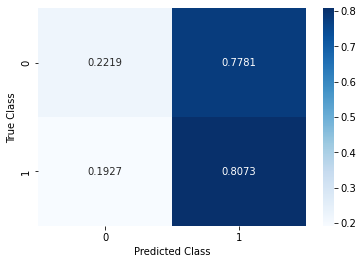

In [ ]:
import seaborn as sns

cm = np.sum(best_cm, axis=0)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()